<center><font color="lightbeige" size=+1.0><b>Data feature selection / extraction using SCI-XAI pipeline</b></font><center>

<font color="bluegrey" size=+1.0><b>Load and Read dataset</b></font>

In [4]:
import pandas as pd

# Load the dataset
f_path = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(f_path)

print("Data Summary")
print(df.describe())
print("\nMissing Values")
print(df.isnull().sum())

Data Summary
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33

<font color="bluegrey" size=+1.0><b>Handling missing data</b></font>

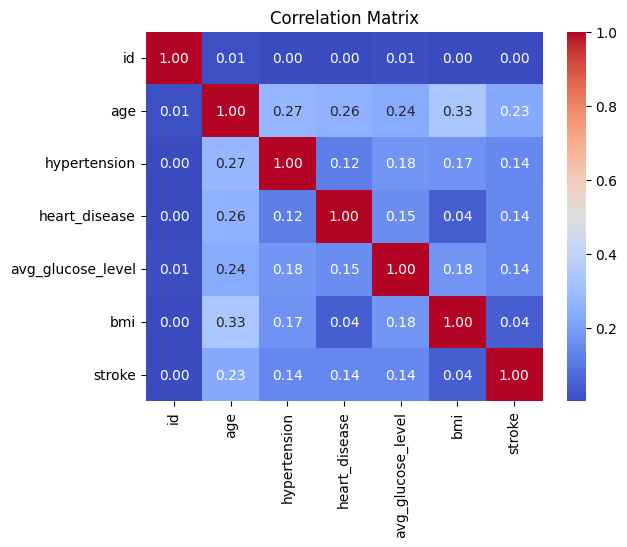

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df['bmi'].replace('N/A', np.nan, inplace=True)
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

df.dropna(inplace=True)

# numeric columns
numeric_columns = df.select_dtypes(include=np.number)

# Visualize correlations
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

<font color="bluegrey" size=+1.0><b>Standardisation</b></font>

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_values = scaler.fit_transform(numeric_columns)

# Converts scaled values back to DataFrame
df_scaled = pd.DataFrame(scaled_values, columns=numeric_columns.columns)

# Concatenates non-numeric columns with the scaled numeric columns
non_numeric_columns = df.drop(columns=numeric_columns.columns)
df_scaled = pd.concat([non_numeric_columns, df_scaled], axis=1)

<font color="bluegrey" size=+1.0><b>SCI-XAI pipeline and feature selection</b></font>

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


selected_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']
X = pd.get_dummies(df[selected_features], columns=['smoking_status'])
y = df['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection using Gradient Boosting for stroke prediction
model_gradient_boosting = GradientBoostingClassifier(random_state=42)
model_gradient_boosting.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

<font color="bluegrey" size=+1.0><b>Data exploration</b></font>

In [8]:
print("Selected Features:")
print(selected_features)

# Display summary statistics of the selected features
print(df[selected_features].describe())

Selected Features:
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']
               age  hypertension  heart_disease  avg_glucose_level  \
count  4909.000000   4909.000000    4909.000000        4909.000000   
mean     42.865374      0.091872       0.049501         105.305150   
std      22.555115      0.288875       0.216934          44.424341   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.070000   
50%      44.000000      0.000000       0.000000          91.680000   
75%      60.000000      0.000000       0.000000         113.570000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi  
count  4909.000000  
mean     28.893237  
std       7.854067  
min      10.300000  
25%      23.500000  
50%      28.100000  
75%      33.100000  
max      97.600000  


<font color="bluegrey" size=+1.0><b>XAI techniques - LIME, SHAP and Anchor</b></font>

c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


LIME Explanation:


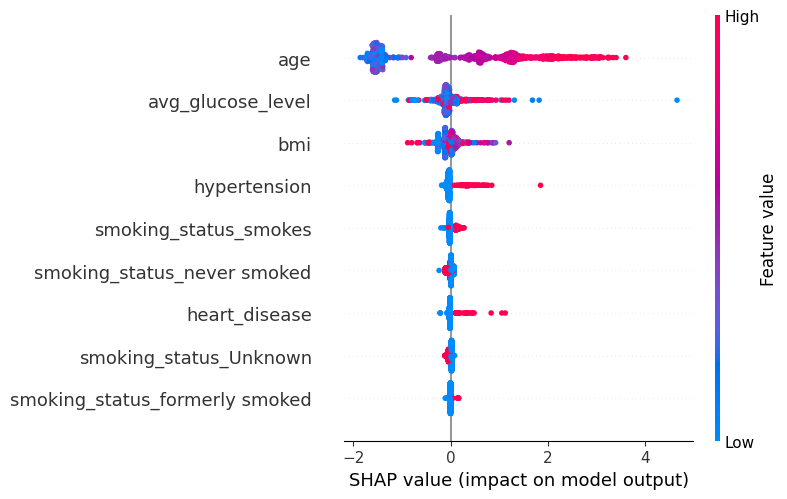

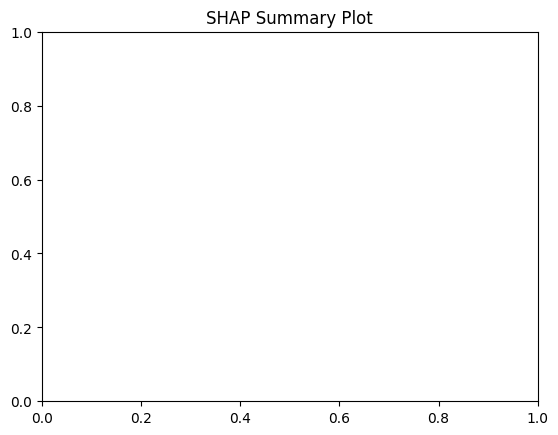

   gender  hypertension  heart_disease ever_married      work_type  \
0    Male             0              1          Yes        Private   
2    Male             0              1          Yes        Private   
3  Female             0              0          Yes        Private   
4  Female             1              0          Yes  Self-employed   
5    Male             0              0          Yes        Private   

  Residence_type   smoking_status  
0          Urban  formerly smoked  
2          Rural     never smoked  
3          Urban           smokes  
4          Rural     never smoked  
5          Urban  formerly smoked  


IndexError: list index out of range

In [9]:
import shap
import random
import matplotlib.pyplot as plt
from lime import lime_tabular
from anchor import anchor_tabular
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# LIME for explaining individual predictions
lime_explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode='classification', feature_names=X_train.columns.to_list())
instance_to_explain = X_test.iloc[0]
lime_explanation = lime_explainer.explain_instance(instance_to_explain.values, model_gradient_boosting.predict_proba)
print("LIME Explanation:")
print(lime_explanation)

# SHAP for feature importance
explainer = shap.TreeExplainer(model_gradient_boosting)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.to_list())
plt.title('SHAP Summary Plot')
plt.show()

# Instance plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], instance_to_explain, feature_names=X_test.columns.to_list())

class_names = ['No Stroke', 'Stroke']

categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'avg_glucose_level', 'bmi']

feature_names = categorical_features + numerical_features

# Defines df_categorical containing the categorical features
df_categorical = df[categorical_features].copy()

# Verify df_categorical
print(df_categorical.head())

# Encode categorical features
label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    df_categorical[feature] = label_encoders[feature].fit_transform(df_categorical[feature])

one_hot_encoder = OneHotEncoder()
X_categorical_encoded = one_hot_encoder.fit_transform(df_categorical[categorical_features]).toarray()

X_encoded = np.concatenate((X_categorical_encoded, df[numerical_features].values), axis=1)
y_binary = (df['stroke'] == 1).astype(int)

feature_names_encoded = list(df_categorical.columns) + numerical_features

# Anchor test
explainer = anchor_tabular.AnchorTabularExplainer(class_names, feature_names, X_encoded, categorical_names=dict(zip(feature_names, [list(df[col].unique()) for col in df_categorical.columns])), discretizer='quartile')
explainer.fit(X_encoded, y_binary)

# Selects a random instance
idx = random.randint(0, len(X_encoded) - 1)
instance = X_encoded[idx]

# Explains the prediction using an anchor
explanation = explainer.explain_instance(instance, model_gradient_boosting.predict_proba, threshold=0.95)
print(explanation['names'])
print(explanation['precision'])
print(explanation['coverage'])

<font color="bluegrey" size=+1.0><b>Research Question 1 → How does age influence the likelihood of stroke occurrence?</b></font>

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(df['age'].values.reshape(-1, 1), y_binary, test_size=0.2, random_state=42)

# Training logistic regression model
logreg_age = LogisticRegression()
logreg_age.fit(X_train_age, y_train_age)

# Extract coefficients
coefficients = logreg_age.coef_[0]

print("Coefficient for age:", coefficients[0])

# Predictions on test set
y_pred_age = logreg_age.predict(X_test_age)

accuracy_age = accuracy_score(y_test_age, y_pred_age)
print("Accuracy:", accuracy_age)

print("Classification Report:")
print(classification_report(y_test_age, y_pred_age))

Coefficient for age: 0.07444730648292162
Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [11]:
###                        Visualisations                  ###
import squarify
import seaborn as sns
import matplotlib.pyplot as plt

# Custom color palette with neon colours
neon_palette = sns.color_palette(["#4e5ae8", "#61f5f5", "#ff6ac1"])

# Seaborn theme for consistent styling
sns.set_theme()

# Colour palette for seaborn and matplotlib
sns.set_palette(neon_palette)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=neon_palette)

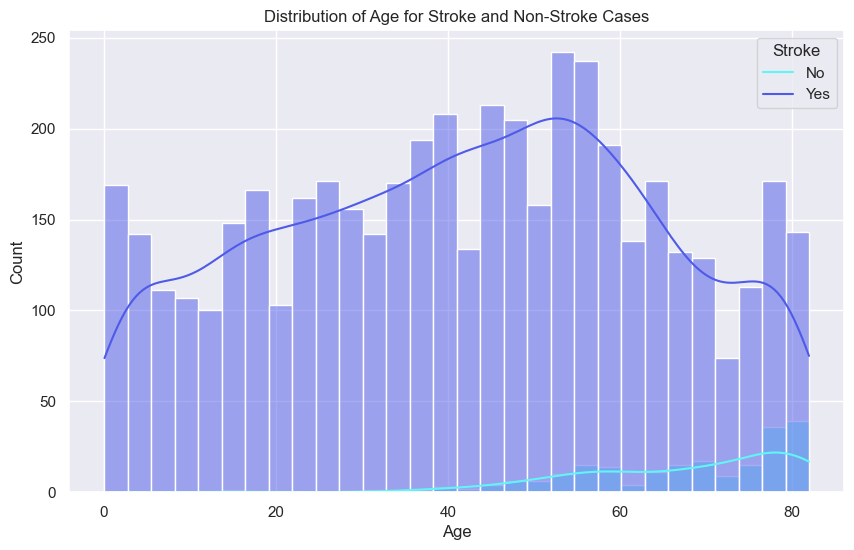

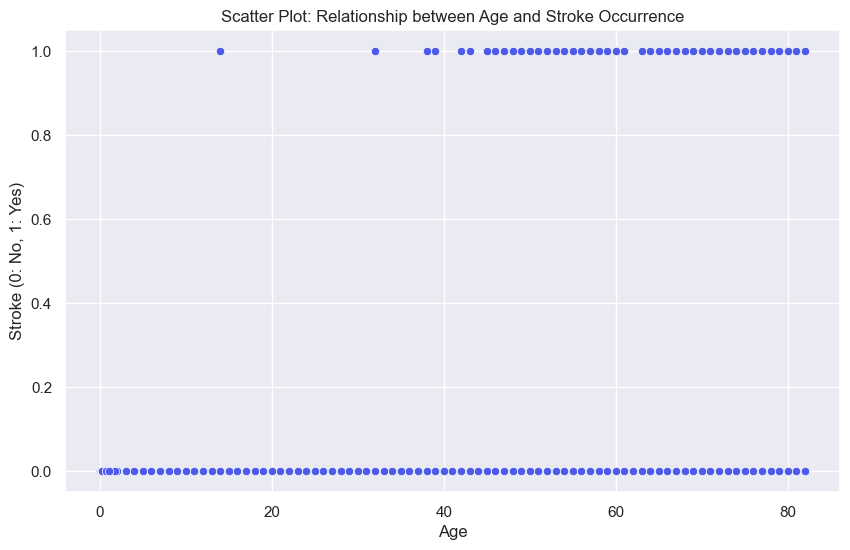

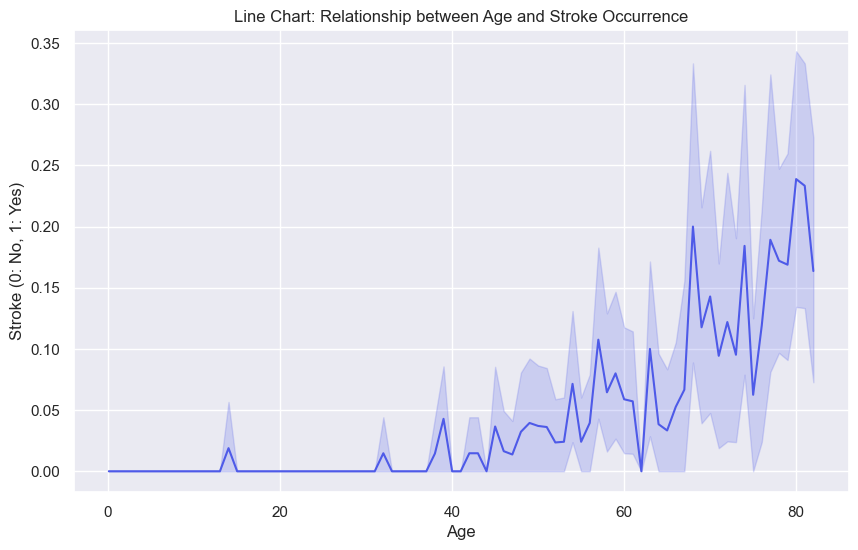

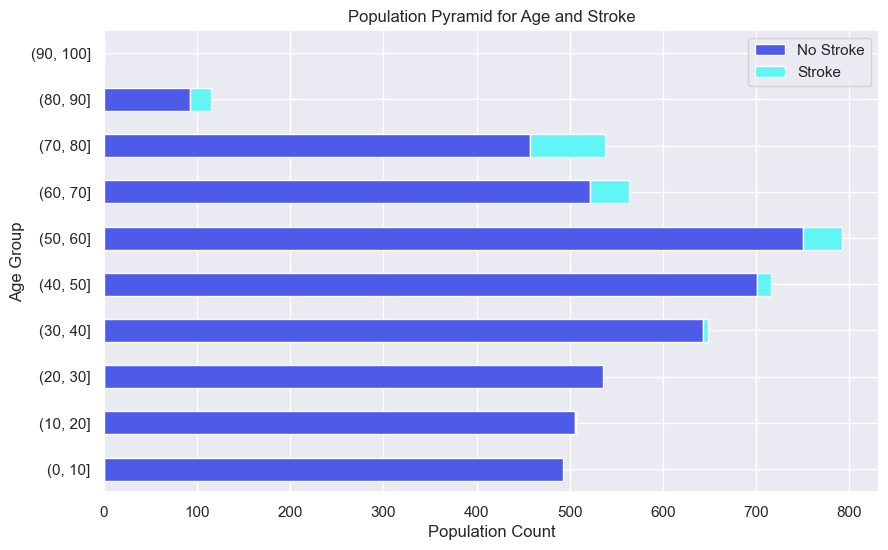

In [12]:
# Summary plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='stroke', bins=30, kde=True)
plt.title('Distribution of Age for Stroke and Non-Stroke Cases')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Stroke', labels=['No', 'Yes'])
plt.show()

# Scatter plot for age and stroke
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='stroke', data=df)
plt.title('Scatter Plot: Relationship between Age and Stroke Occurrence')
plt.xlabel('Age')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Line chart for age and stroke
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='age', y='stroke')
plt.title('Line Chart: Relationship between Age and Stroke Occurrence')
plt.xlabel('Age')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid for age and stroke
age_bins = pd.cut(df['age'], bins=np.arange(0, 101, 10))
age_stroke_counts = df.groupby([age_bins, 'stroke']).size().unstack(fill_value=0)
age_stroke_counts.columns = ['No Stroke', 'Stroke']
age_stroke_counts.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.title('Population Pyramid for Age and Stroke')
plt.xlabel('Population Count')
plt.ylabel('Age Group')
plt.show()

<font color="bluegrey" size=+1.0><b>Research Question 2 → Is there a relationship between hypertension and stroke risk?</b></font>

In [13]:
# Decision trees
from sklearn.tree import DecisionTreeClassifier

X_train_hypertension, X_test_hypertension, y_train_hypertension, y_test_hypertension = train_test_split(df['hypertension'].values.reshape(-1, 1), y_binary, test_size=0.2, random_state=42)

# Training decision tree classifier
dt_hypertension = DecisionTreeClassifier()
dt_hypertension.fit(X_train_hypertension, y_train_hypertension)

# Predictions on test set
y_pred_hypertension = dt_hypertension.predict(X_test_hypertension)

accuracy_hypertension = accuracy_score(y_test_hypertension, y_pred_hypertension)
print("Accuracy:", accuracy_hypertension)

print("Classification Report:")
print(classification_report(y_test_hypertension, y_pred_hypertension))

Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

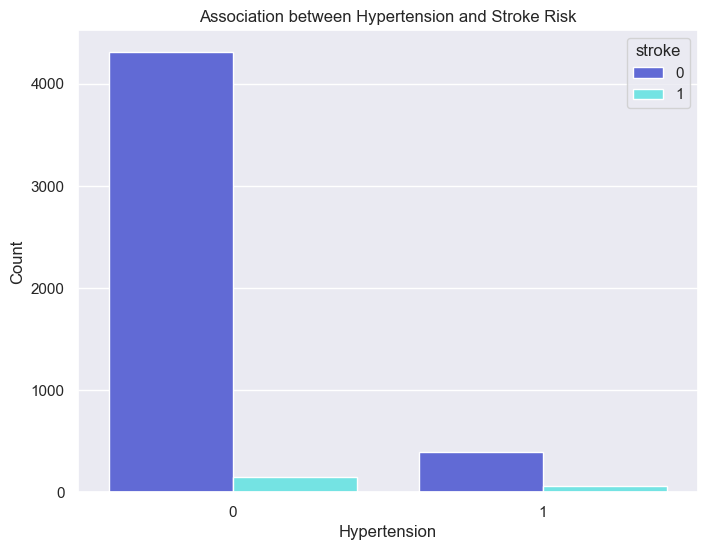

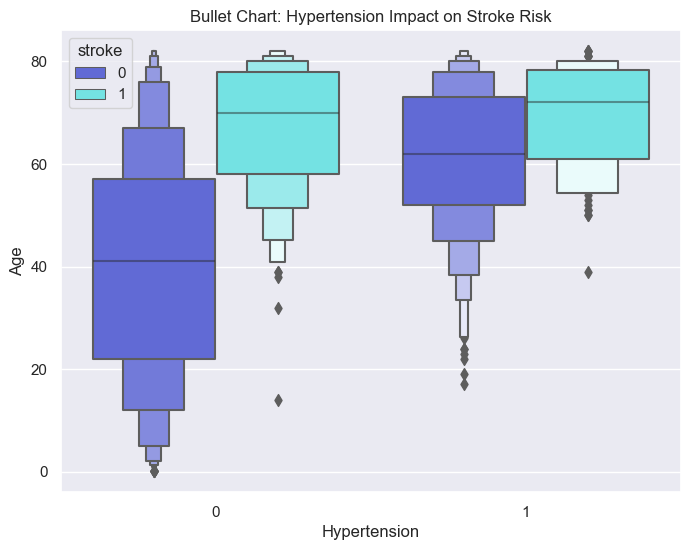

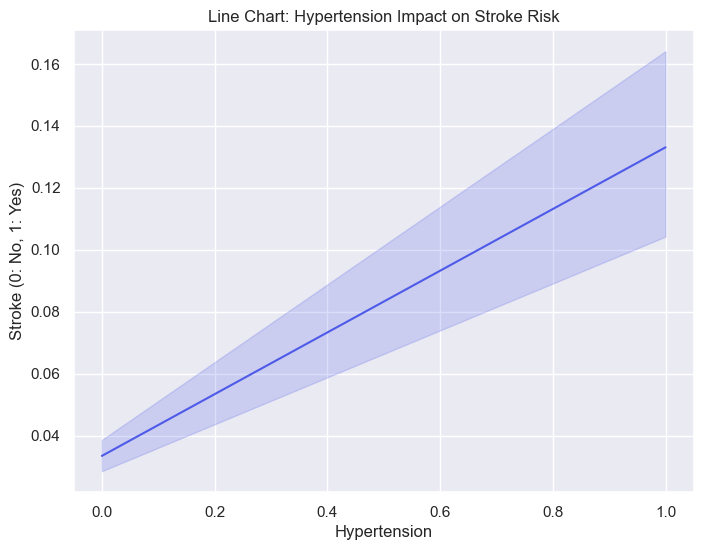

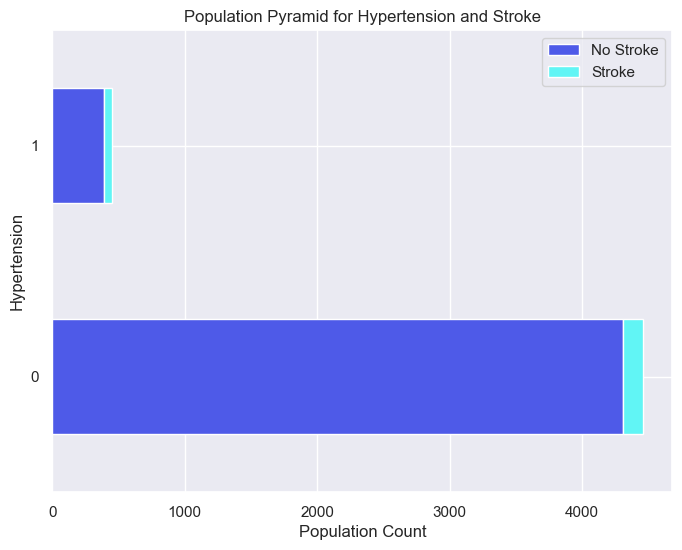

In [14]:
# Summary plot for hypertension
plt.figure(figsize=(8, 6))
sns.countplot(x='hypertension', hue='stroke', data=df)
plt.title('Association between Hypertension and Stroke Risk')
plt.xlabel('Hypertension')
plt.ylabel('Count')
plt.show()

# Bullet chart for hypertension
plt.figure(figsize=(8, 6))
sns.boxenplot(x='hypertension', y='age', hue='stroke', data=df)
plt.title('Bullet Chart: Hypertension Impact on Stroke Risk')
plt.xlabel('Hypertension')
plt.ylabel('Age')
plt.show()

# Line chart for hypertension
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='hypertension', y='stroke')
plt.title('Line Chart: Hypertension Impact on Stroke Risk')
plt.xlabel('Hypertension')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid for hypertension
hypertension_stroke_counts = df.groupby(['hypertension', 'stroke']).size().unstack(fill_value=0)
hypertension_stroke_counts.columns = ['No Stroke', 'Stroke']
hypertension_stroke_counts.plot(kind='barh', stacked=True, figsize=(8, 6))
plt.title('Population Pyramid for Hypertension and Stroke')
plt.xlabel('Population Count')
plt.ylabel('Hypertension')
plt.show()


<font color="bluegrey" size=+1.0><b>Research Question 3 → How does gender influence the absence of stroke?</b></font>

In [15]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

y_non_stroke = 1 - y_binary

# Splitting the dataset
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(df['gender'].values.reshape(-1, 1), y_non_stroke, test_size=0.2, random_state=42)

# Label encode 'gender' feature
label_encoder_gender = LabelEncoder()
X_train_gender_encoded = label_encoder_gender.fit_transform(X_train_gender.ravel())
X_test_gender_encoded = label_encoder_gender.transform(X_test_gender.ravel())

# Training random forest classifier
rf_gender = RandomForestClassifier()
rf_gender.fit(X_train_gender_encoded.reshape(-1, 1), y_train_gender)

# Predictions on test set
y_pred_gender = rf_gender.predict(X_test_gender_encoded.reshape(-1, 1))

accuracy_gender = accuracy_score(y_test_gender, y_pred_gender)
print("Accuracy:", accuracy_gender)

print("Classification Report:")
print(classification_report(y_test_gender, y_pred_gender))

Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.95      1.00      0.97       929

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

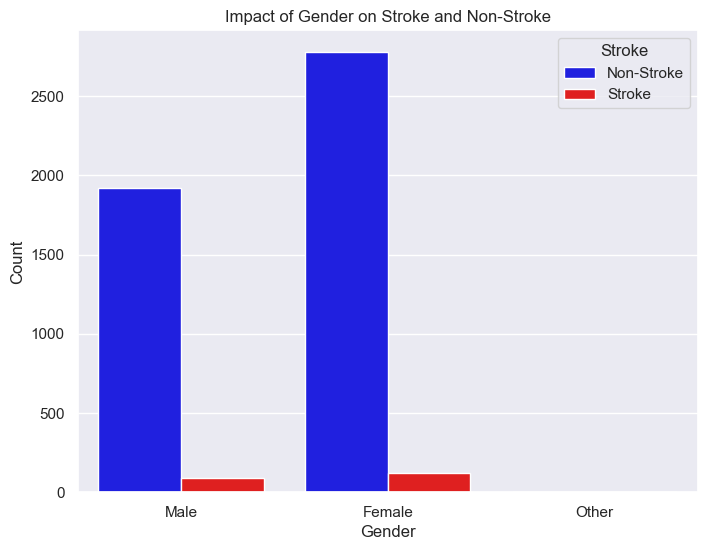

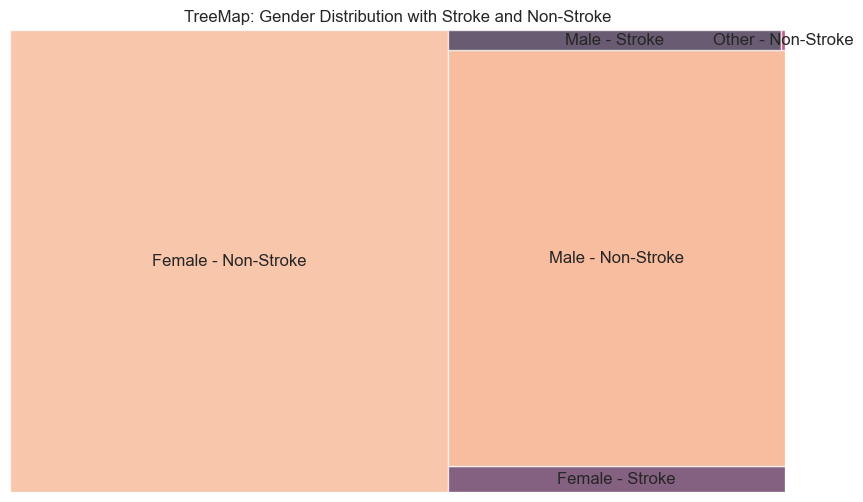

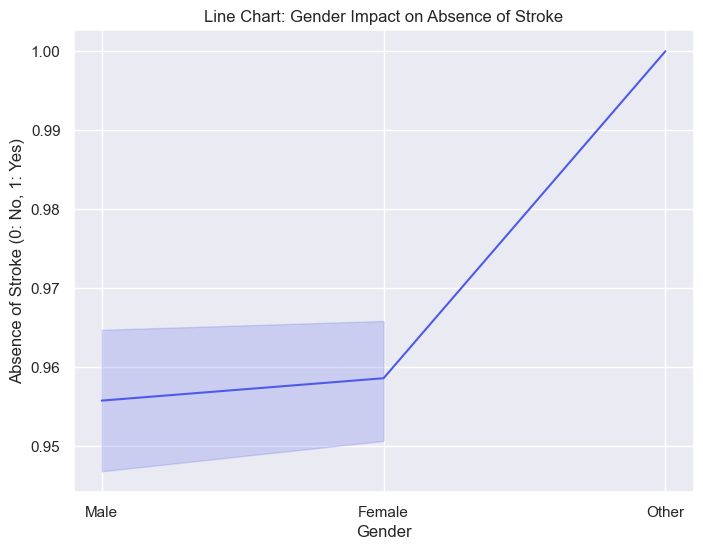

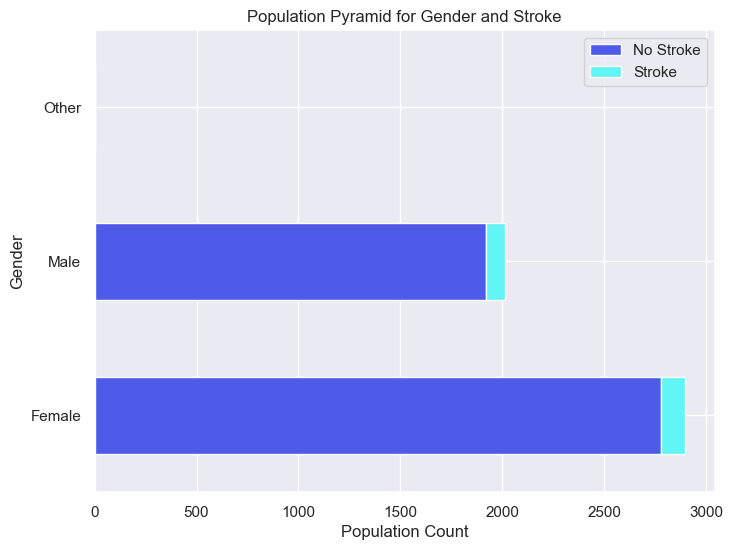

In [20]:
# Summary plot 
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='stroke', data=df, palette={0: "blue", 1: "red"})
plt.title('Impact of Gender on Stroke and Non-Stroke')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Stroke', labels=['Non-Stroke', 'Stroke'])
plt.show()

# TreeMap for gender
plt.figure(figsize=(10, 6))
df_gender_count = df.groupby(['gender', 'stroke']).size().reset_index(name='count')
squarify.plot(sizes=df_gender_count['count'], label=df_gender_count.apply(lambda x: f"{x['gender']} - {'Non-Stroke' if x['stroke'] == 0 else 'Stroke'}", axis=1), alpha=0.7)
plt.axis('off')
plt.title('TreeMap: Gender Distribution with Stroke and Non-Stroke')
plt.show()

# Line chart for gender
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='gender', y=1 - df['stroke'])
plt.title('Line Chart: Gender Impact on Absence of Stroke')
plt.xlabel('Gender')
plt.ylabel('Absence of Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid for gender
gender_stroke_counts = df.groupby(['gender', 'stroke']).size().unstack(fill_value=0)
gender_stroke_counts.columns = ['No Stroke', 'Stroke']
gender_stroke_counts.plot(kind='barh', stacked=True, figsize=(8, 6))
plt.title('Population Pyramid for Gender and Stroke')
plt.xlabel('Population Count')
plt.ylabel('Gender')
plt.show()

<font color="bluegrey" size=+1.0><b>Research Question 4 → What is the relationship between smoking status and the absence of stroke?</b></font>

In [21]:
# XGBoost
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder

y_non_stroke = 1 - y_binary

# Splitting the dataset
X_train_smoking, X_test_smoking, y_train_smoking, y_test_smoking = train_test_split(df['smoking_status'].values.reshape(-1, 1), y_non_stroke, test_size=0.2, random_state=42)

# One-hot encode 'smoking_status' feature
encoder_smoking = OneHotEncoder(sparse=False)
X_train_smoking_encoded = encoder_smoking.fit_transform(X_train_smoking)
X_test_smoking_encoded = encoder_smoking.transform(X_test_smoking)

# Training XGBoost classifier
xgb_smoking = XGBClassifier()
xgb_smoking.fit(X_train_smoking_encoded, y_train_smoking)

# Predictions on test set
y_pred_smoking = xgb_smoking.predict(X_test_smoking_encoded)

accuracy_smoking = accuracy_score(y_test_smoking, y_pred_smoking)
print("Accuracy:", accuracy_smoking)

print("Classification Report:")
print(classification_report(y_test_smoking, y_pred_smoking))

c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.95      1.00      0.97       929

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

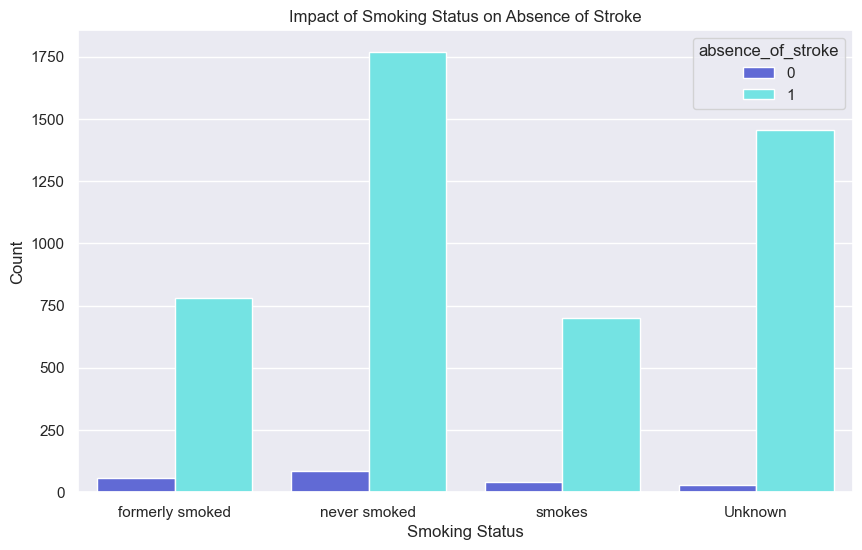

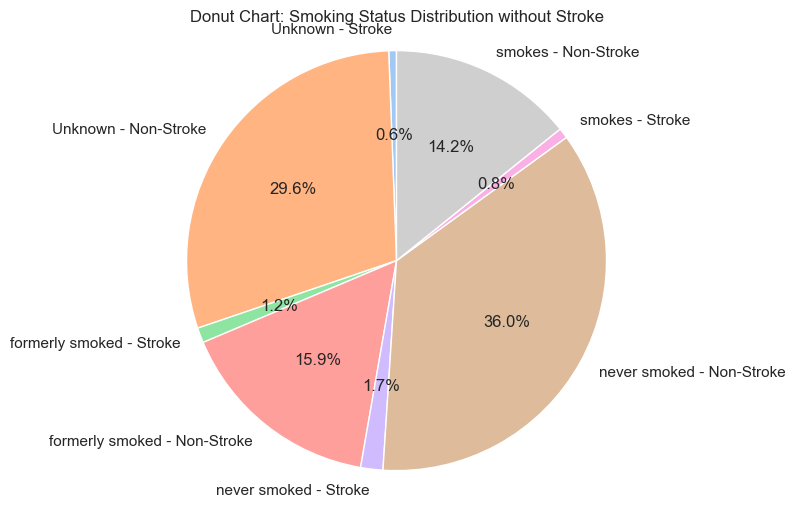

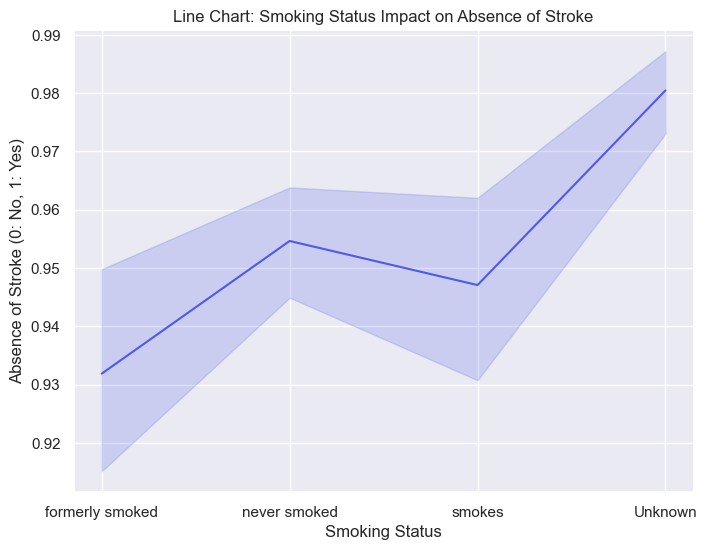

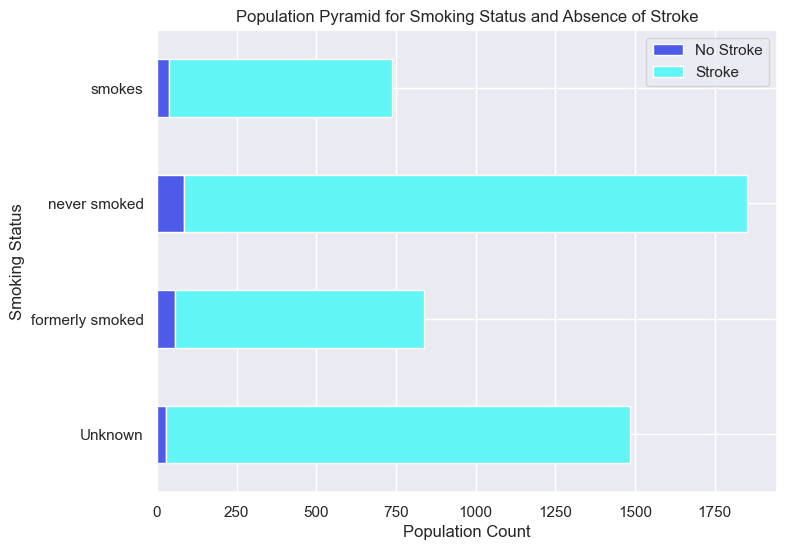

In [25]:
df['absence_of_stroke'] = 1 - df['stroke']

# Summary plot for smoking status
plt.figure(figsize=(10, 6))
sns.countplot(x='smoking_status', hue='absence_of_stroke', data=df)
plt.title('Impact of Smoking Status on Absence of Stroke')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.show()

# Donut chart for smoking status
plt.figure(figsize=(8, 6))
df_smoking_count = df.groupby(['smoking_status', 'absence_of_stroke']).size().reset_index(name='count')
plt.pie(df_smoking_count['count'], labels=df_smoking_count.apply(lambda x: f"{x['smoking_status']} - {'Non-Stroke' if x['absence_of_stroke'] == 1 else 'Stroke'}", axis=1), autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Donut Chart: Smoking Status Distribution without Stroke')
plt.axis('equal')
plt.show()

# Line chart for smoking status
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='smoking_status', y=1 - df['stroke'])
plt.title('Line Chart: Smoking Status Impact on Absence of Stroke')
plt.xlabel('Smoking Status')
plt.ylabel('Absence of Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid for smoking status
smoking_absence_counts = df.groupby(['smoking_status', 'absence_of_stroke']).size().unstack(fill_value=0)
smoking_absence_counts.columns = ['No Stroke', 'Stroke']
smoking_absence_counts.plot(kind='barh', stacked=True, figsize=(8, 6))
plt.title('Population Pyramid for Smoking Status and Absence of Stroke')
plt.xlabel('Population Count')
plt.ylabel('Smoking Status')
plt.show()

<font color="bluegrey" size=+1.0><b>Research Question 5 → Does average glucose level correlate with the probability of stroke?</b></font>

In [26]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train_glucose, X_test_glucose, y_train_glucose, y_test_glucose = train_test_split(df['avg_glucose_level'].values.reshape(-1, 1), df['stroke'], test_size=0.2, random_state=42)

# Training linear regression model
linreg_glucose = LinearRegression()
linreg_glucose.fit(X_train_glucose, y_train_glucose)

# Predictions on test set
y_pred_glucose = linreg_glucose.predict(X_test_glucose)

mse_glucose = mean_squared_error(y_test_glucose, y_pred_glucose)
print("Mean Squared Error:", mse_glucose)

Mean Squared Error: 0.05067097268229937


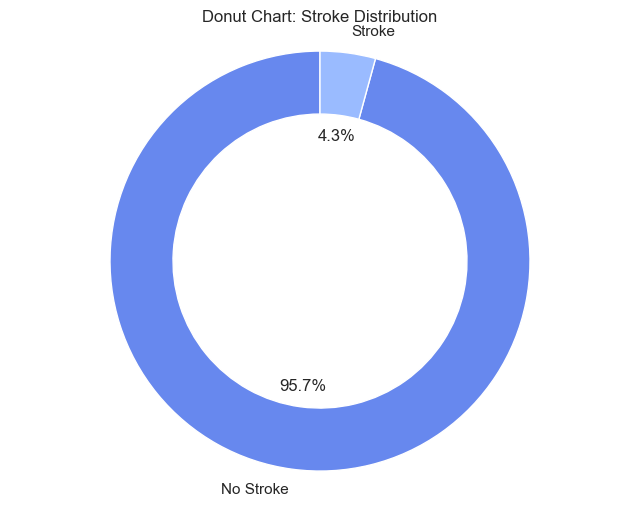

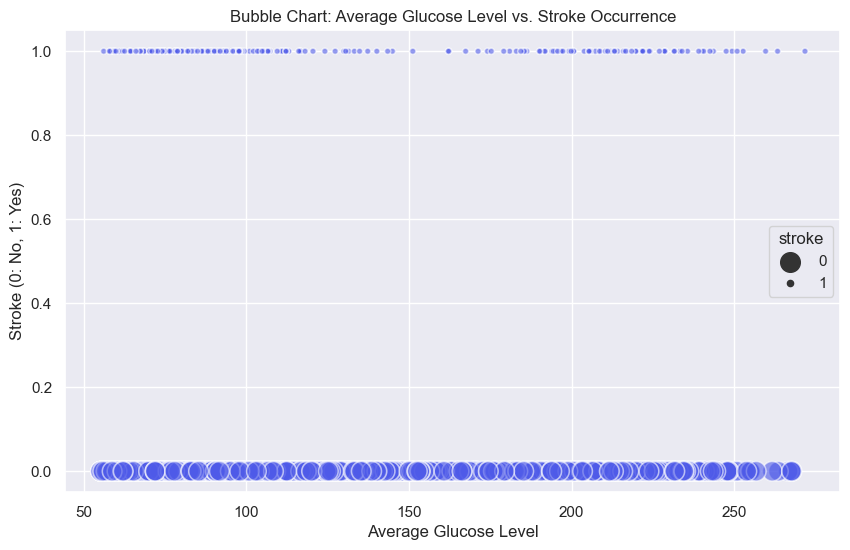

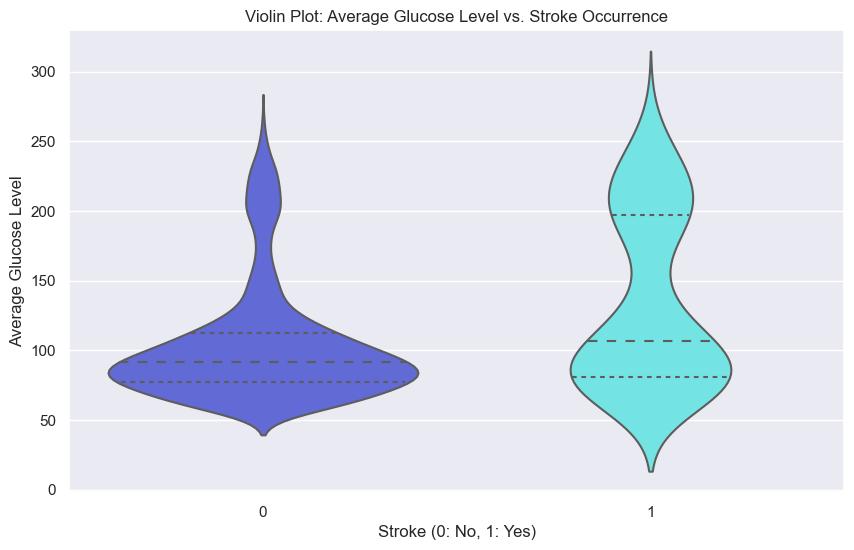

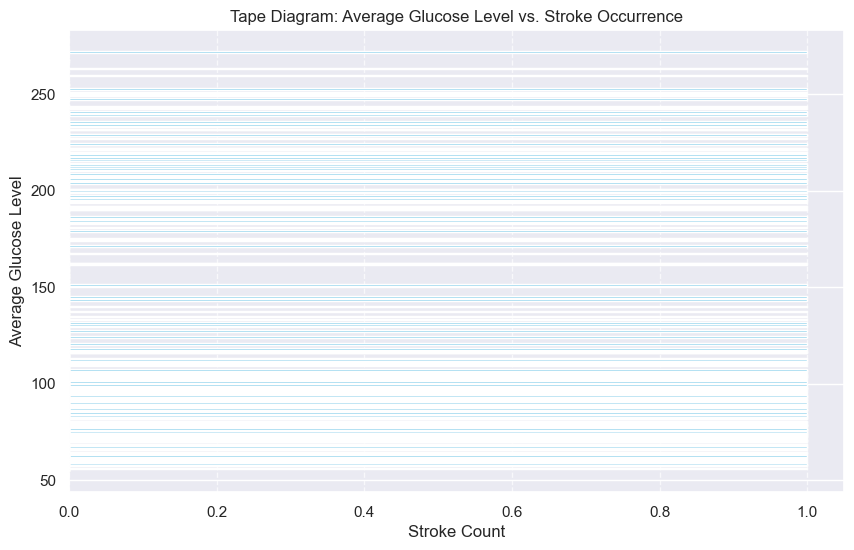

C:\Users\zen\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128522 (\N{SMILING FACE WITH SMILING EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


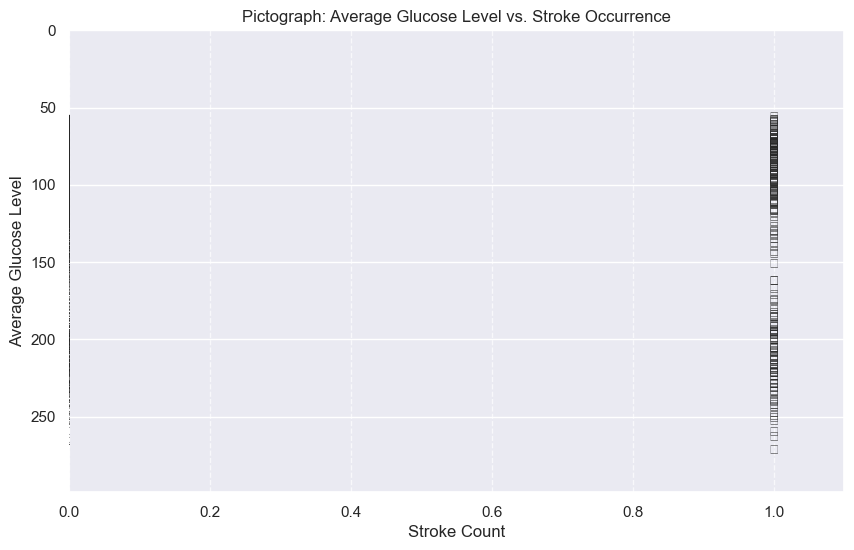

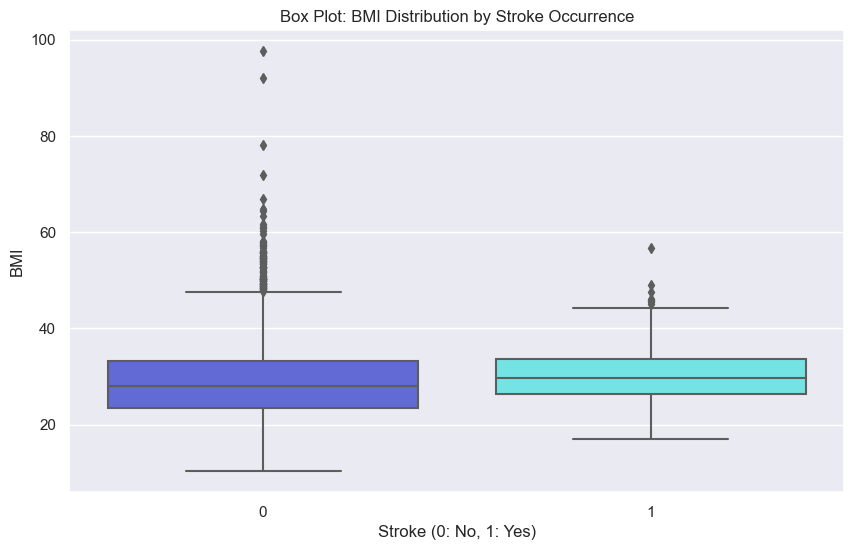

In [27]:
# Donut chart for average glucose level
plt.figure(figsize=(8, 6))
df_glucose_count = df.groupby(['stroke']).size().reset_index(name='count')
plt.pie(df_glucose_count['count'], labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm'), wedgeprops=dict(width=0.3))
plt.title('Donut Chart: Stroke Distribution')
plt.axis('equal')
plt.show()

# Bubble Chart
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='avg_glucose_level', y='stroke', size='stroke', sizes=(20, 200), alpha=0.6)
plt.title('Bubble Chart: Average Glucose Level vs. Stroke Occurrence')
plt.xlabel('Average Glucose Level')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='stroke', y='avg_glucose_level', inner='quartile')
plt.title('Violin Plot: Average Glucose Level vs. Stroke Occurrence')
plt.xlabel('Stroke (0: No, 1: Yes)')
plt.ylabel('Average Glucose Level')
plt.show()

stroke_counts = df.groupby('avg_glucose_level')['stroke'].sum()

# Tape diagram
plt.figure(figsize=(10, 6))
plt.barh(stroke_counts.index, stroke_counts, color='skyblue')
plt.title('Tape Diagram: Average Glucose Level vs. Stroke Occurrence')
plt.xlabel('Stroke Count')
plt.ylabel('Average Glucose Level')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# pictograph
symbol = '😊'

plt.figure(figsize=(10, 6))
for level, count in stroke_counts.items():
    plt.text(count, level, symbol, fontsize=count*10, ha='center', va='center')

plt.title('Pictograph: Average Glucose Level vs. Stroke Occurrence')
plt.xlabel('Stroke Count')
plt.ylabel('Average Glucose Level')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, stroke_counts.max() * 1.1)
plt.ylim(0, stroke_counts.index.max() * 1.1)
plt.gca().invert_yaxis()  # Invert y-axis to align with typical axis direction
plt.show()

# box and whisker plot 
plt.figure(figsize=(10, 6))
sns.boxplot(x='stroke', y='bmi', data=df)
plt.title('Box Plot: BMI Distribution by Stroke Occurrence')
plt.xlabel('Stroke (0: No, 1: Yes)')
plt.ylabel('BMI')
plt.show()

<font color="bluegrey" size=+1.0><b>Research Question 6 → How does the type of work affect the likelihood of stroke?</b></font>

In [28]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

X_train_work, X_test_work, y_train_work, y_test_work = train_test_split(df['work_type'].values.reshape(-1, 1), y_binary, test_size=0.2, random_state=42)

# One-hot encode 'work_type' feature
encoder_work = OneHotEncoder(sparse=False)
X_train_work_encoded = encoder_work.fit_transform(X_train_work)
X_test_work_encoded = encoder_work.transform(X_test_work)

# Training model
logreg_work = LogisticRegression()
logreg_work.fit(X_train_work_encoded, y_train_work)

# Predictions on test set
y_pred_work = logreg_work.predict(X_test_work_encoded)

accuracy_work = accuracy_score(y_test_work, y_pred_work)
print("Accuracy:", accuracy_work)

print("Classification Report:")
print(classification_report(y_test_work, y_pred_work))


Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\

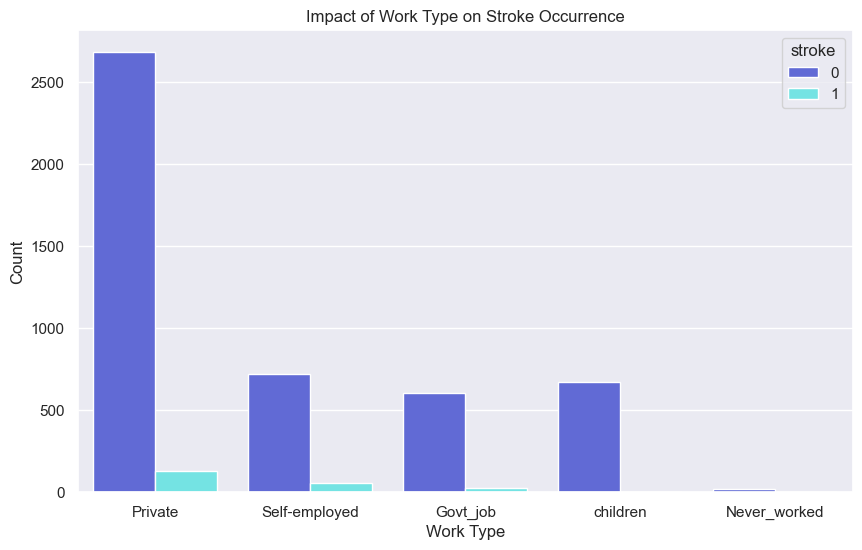

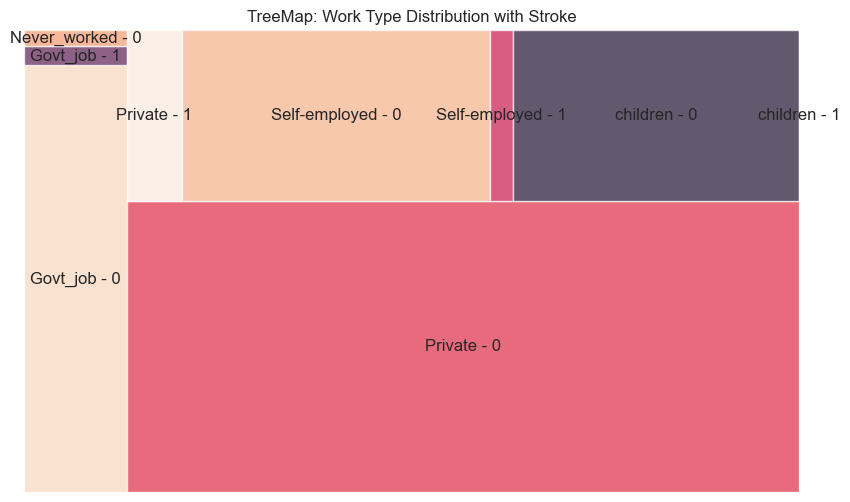

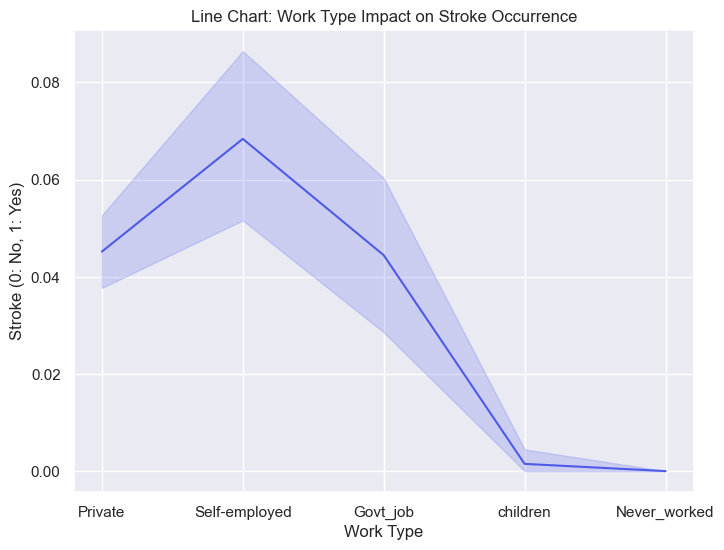

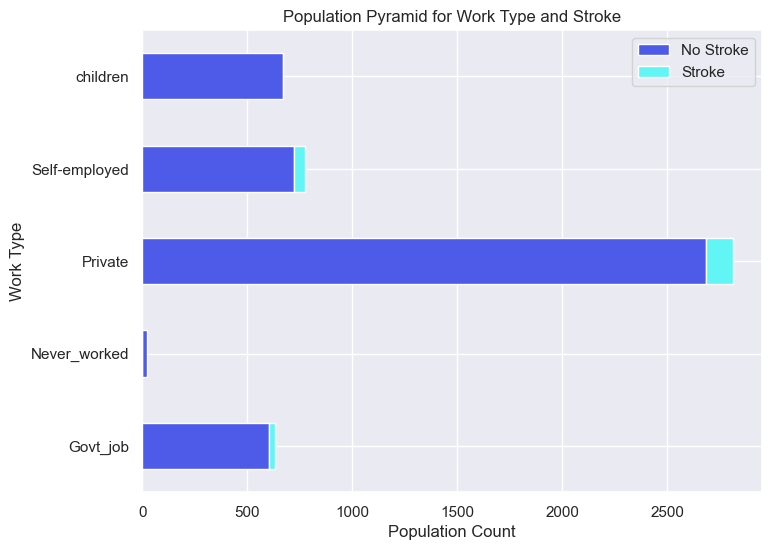

In [29]:
# Plotting the impact of work type on stroke occurrence
plt.figure(figsize=(10, 6))
sns.countplot(x='work_type', hue='stroke', data=df)
plt.title('Impact of Work Type on Stroke Occurrence')
plt.xlabel('Work Type')
plt.ylabel('Count')
plt.show()

# TreeMap for work type
plt.figure(figsize=(10, 6))
df_work_count = df.groupby(['work_type', 'stroke']).size().reset_index(name='count')
squarify.plot(sizes=df_work_count['count'], label=df_work_count.apply(lambda x: f"{x['work_type']} - {x['stroke']}", axis=1), alpha=0.7)
plt.axis('off')
plt.title('TreeMap: Work Type Distribution with Stroke')
plt.show()

# Line chart for work type
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='work_type', y='stroke')
plt.title('Line Chart: Work Type Impact on Stroke Occurrence')
plt.xlabel('Work Type')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid for work type
work_stroke_counts = df.groupby(['work_type', 'stroke']).size().unstack(fill_value=0)
work_stroke_counts.columns = ['No Stroke', 'Stroke']
work_stroke_counts.plot(kind='barh', stacked=True, figsize=(8, 6))
plt.title('Population Pyramid for Work Type and Stroke')
plt.xlabel('Population Count')
plt.ylabel('Work Type')
plt.show()


<font color="bluegrey" size=+1.0><b>Research Question 7 → Is there an association between residence type (urban or rural) and stroke risk?</b></font>

In [30]:
from sklearn.preprocessing import LabelEncoder

X_train_residence, X_test_residence, y_train_residence, y_test_residence = train_test_split(df['Residence_type'].values.reshape(-1, 1), y_binary, test_size=0.2, random_state=42)

# Label encode 'Residence_type' feature
label_encoder_residence = LabelEncoder()
X_train_residence_encoded = label_encoder_residence.fit_transform(X_train_residence.ravel())
X_test_residence_encoded = label_encoder_residence.transform(X_test_residence.ravel())

# Reshape encoded features
X_train_residence_encoded = X_train_residence_encoded.reshape(-1, 1)
X_test_residence_encoded = X_test_residence_encoded.reshape(-1, 1)

# Training model
logreg_residence = LogisticRegression()
logreg_residence.fit(X_train_residence_encoded, y_train_residence)

# Predictions on test set
y_pred_residence = logreg_residence.predict(X_test_residence_encoded)

accuracy_residence = accuracy_score(y_test_residence, y_pred_residence)
print("Accuracy:", accuracy_residence)

print("Classification Report:")
print(classification_report(y_test_residence, y_pred_residence))

Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

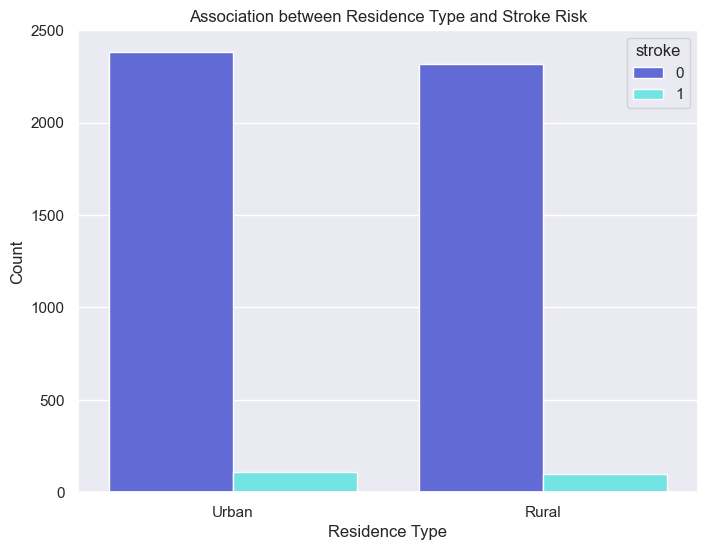

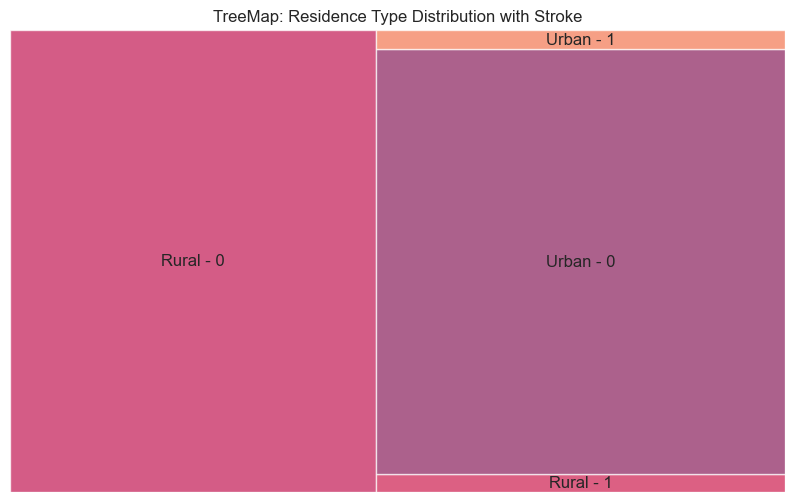

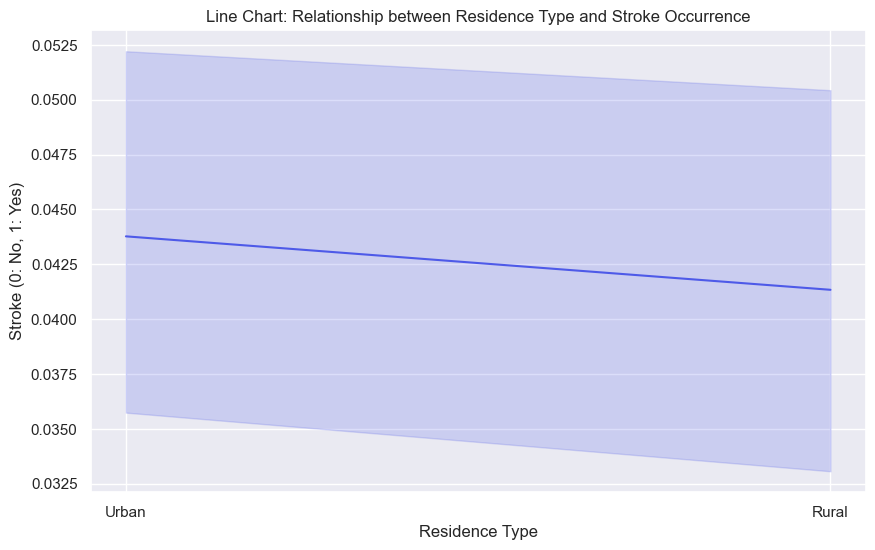

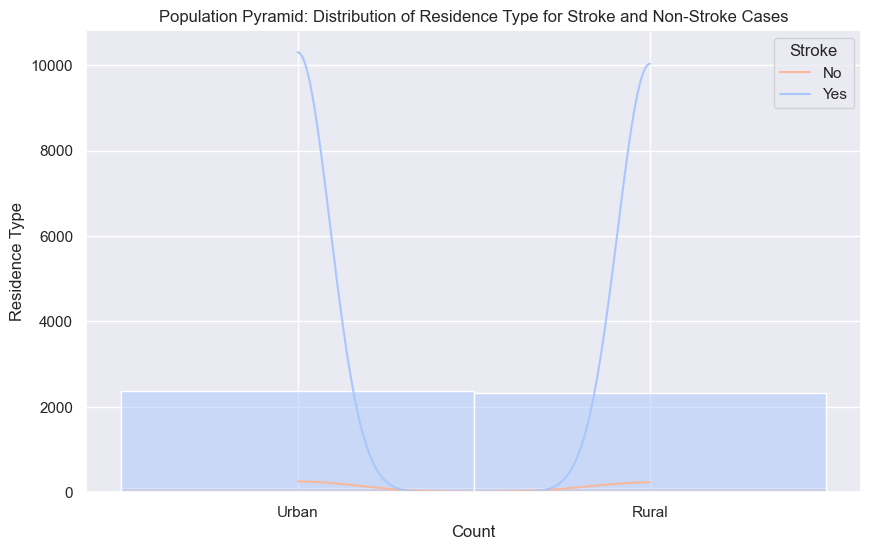

In [31]:
# Plotting the association between residence type and stroke risk
plt.figure(figsize=(8, 6))
sns.countplot(x='Residence_type', hue='stroke', data=df)
plt.title('Association between Residence Type and Stroke Risk')
plt.xlabel('Residence Type')
plt.ylabel('Count')
plt.show()

# TreeMap for residence type
plt.figure(figsize=(10, 6))
df_residence_count = df.groupby(['Residence_type', 'stroke']).size().reset_index(name='count')
squarify.plot(sizes=df_residence_count['count'], label=df_residence_count.apply(lambda x: f"{x['Residence_type']} - {x['stroke']}", axis=1), alpha=0.7)
plt.axis('off')
plt.title('TreeMap: Residence Type Distribution with Stroke')
plt.show()

# Line chart for residence type and stroke
plt.figure(figsize=(10, 6))
sns.lineplot(x='Residence_type', y='stroke', data=df)
plt.title('Line Chart: Relationship between Residence Type and Stroke Occurrence')
plt.xlabel('Residence Type')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid 
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Residence_type', hue='stroke', bins=30, kde=True, multiple='layer', palette='coolwarm')
plt.title('Population Pyramid: Distribution of Residence Type for Stroke and Non-Stroke Cases')
plt.xlabel('Count')
plt.ylabel('Residence Type')
plt.legend(title='Stroke', labels=['No', 'Yes'])
plt.show()


<font color="bluegrey" size=+1.0><b>Research Question 8 → Does marital status influence the probability of stroke occurrence?</b></font>

In [32]:
from sklearn.preprocessing import LabelEncoder

X_train_marital, X_test_marital, y_train_marital, y_test_marital = train_test_split(df['ever_married'].values.reshape(-1, 1), y_binary, test_size=0.2, random_state=42)

# Label encode 'ever_married' feature
label_encoder = LabelEncoder()
X_train_marital_encoded = label_encoder.fit_transform(X_train_marital.ravel())
X_test_marital_encoded = label_encoder.transform(X_test_marital.ravel())

# Reshape encoded features
X_train_marital_encoded = X_train_marital_encoded.reshape(-1, 1)
X_test_marital_encoded = X_test_marital_encoded.reshape(-1, 1)

# Training model
logreg_marital = LogisticRegression()
logreg_marital.fit(X_train_marital_encoded, y_train_marital)

# Predictions on test set
y_pred_marital = logreg_marital.predict(X_test_marital_encoded)

accuracy_marital = accuracy_score(y_test_marital, y_pred_marital)
print("Accuracy:", accuracy_marital)

print("Classification Report:")
print(classification_report(y_test_marital, y_pred_marital))

Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

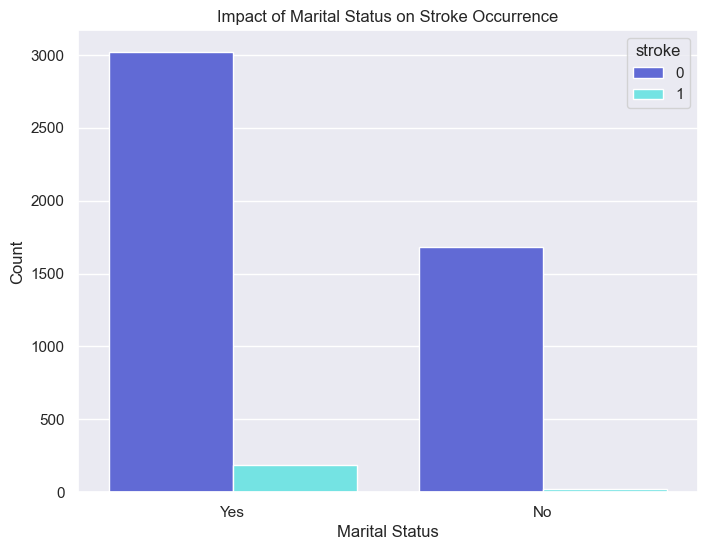

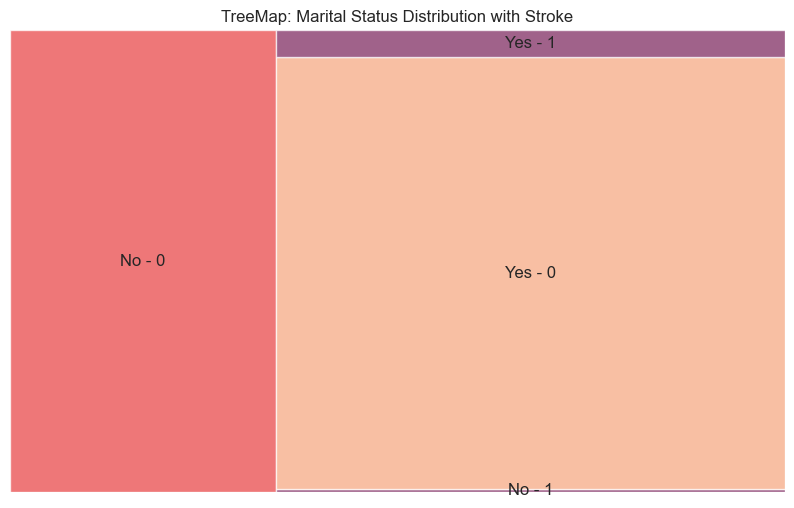

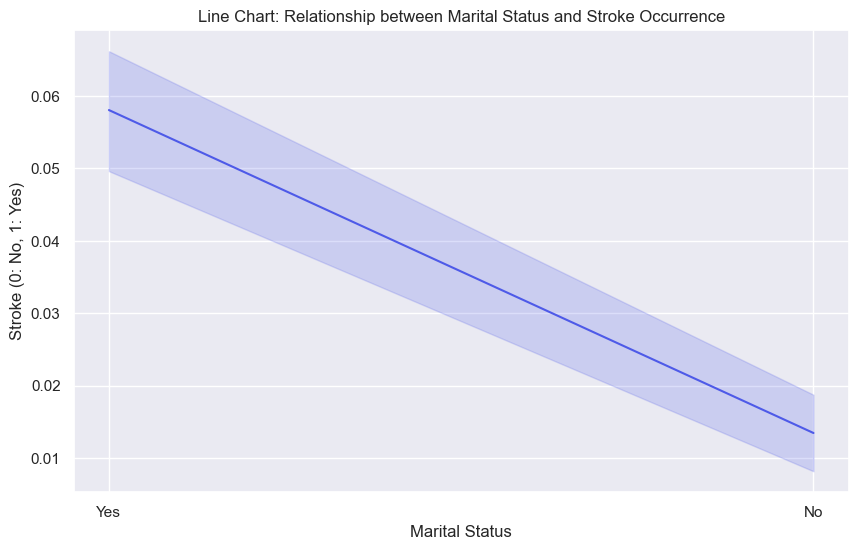

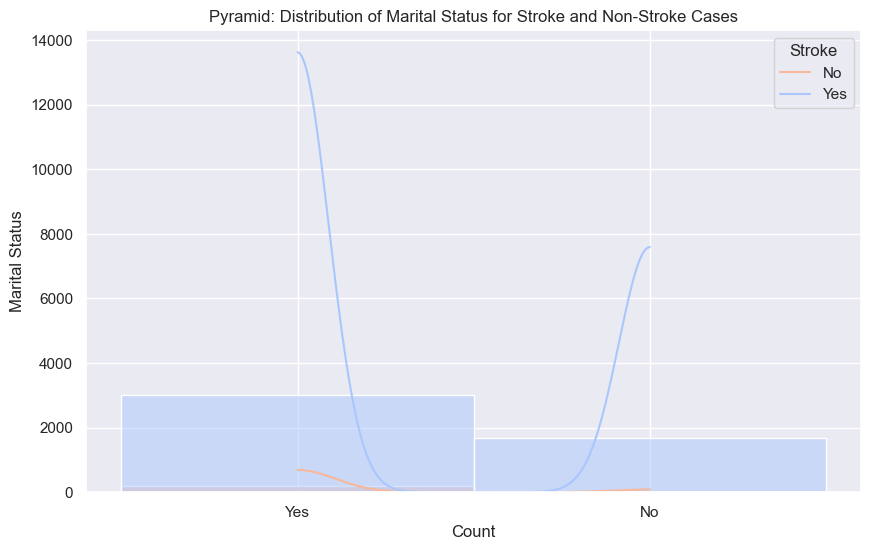

In [33]:
# Plotting the impact of marital status on stroke occurrence
plt.figure(figsize=(8, 6))
sns.countplot(x='ever_married', hue='stroke', data=df)
plt.title('Impact of Marital Status on Stroke Occurrence')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.show()

# TreeMap for marital status
plt.figure(figsize=(10, 6))
df_marital_count = df.groupby(['ever_married', 'stroke']).size().reset_index(name='count')
squarify.plot(sizes=df_marital_count['count'], label=df_marital_count.apply(lambda x: f"{x['ever_married']} - {x['stroke']}", axis=1), alpha=0.7)
plt.axis('off')
plt.title('TreeMap: Marital Status Distribution with Stroke')
plt.show()

# Line chart for marital status and stroke
plt.figure(figsize=(10, 6))
sns.lineplot(x='ever_married', y='stroke', data=df)
plt.title('Line Chart: Relationship between Marital Status and Stroke Occurrence')
plt.xlabel('Marital Status')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='ever_married', hue='stroke', bins=30, kde=True, multiple='layer', palette='coolwarm')
plt.title('Pyramid: Distribution of Marital Status for Stroke and Non-Stroke Cases')
plt.xlabel('Count')
plt.ylabel('Marital Status')
plt.legend(title='Stroke', labels=['No', 'Yes'])
plt.show()


<font color="bluegrey" size=+1.0><b>Research Question 9 → What impact does the presence of heart disease have on the likelihood of stroke?</b></font>

In [34]:
X_train_heart_disease, X_test_heart_disease, y_train_heart_disease, y_test_heart_disease = train_test_split(df['heart_disease'].values.reshape(-1, 1), y_binary, test_size=0.2, random_state=42)

# Training model
logreg_heart_disease = LogisticRegression()
logreg_heart_disease.fit(X_train_heart_disease, y_train_heart_disease)

# Predictions on test set
y_pred_heart_disease = logreg_heart_disease.predict(X_test_heart_disease)

accuracy_heart_disease = accuracy_score(y_test_heart_disease, y_pred_heart_disease)
print("Accuracy:", accuracy_heart_disease)

print("Classification Report:")
print(classification_report(y_test_heart_disease, y_pred_heart_disease))

Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

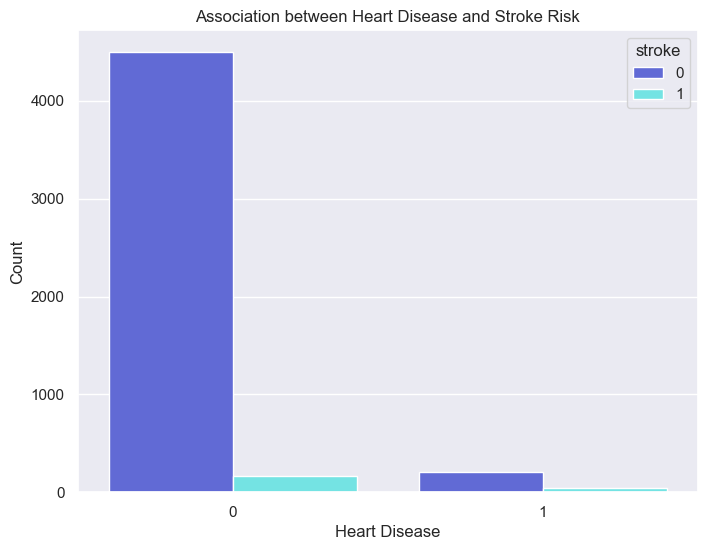

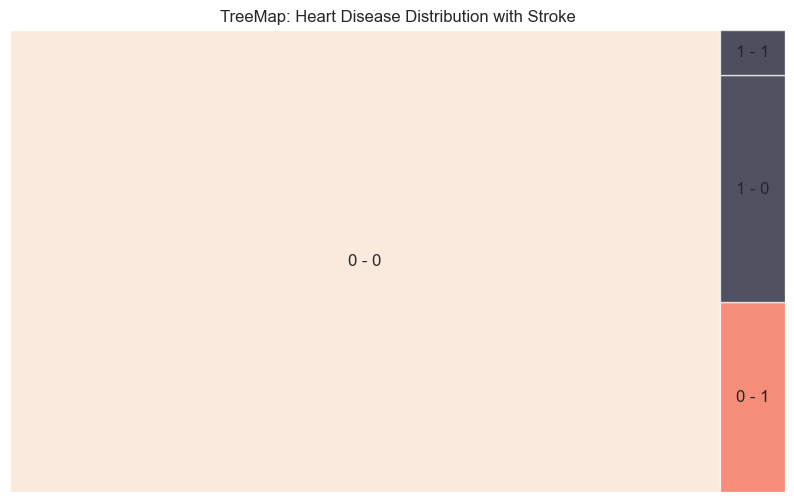

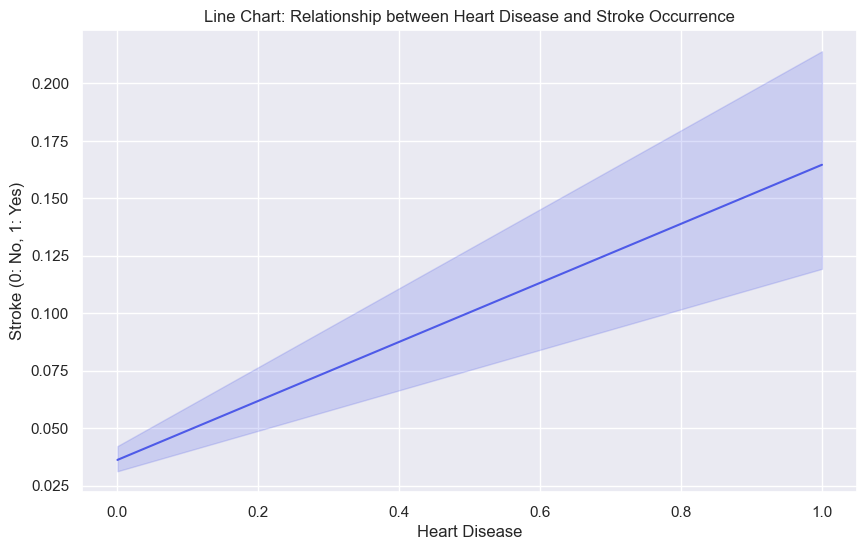

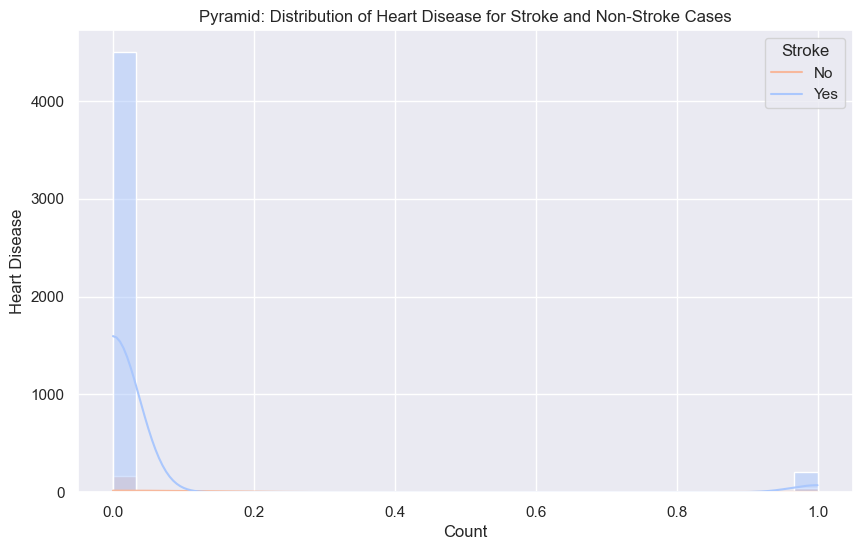

In [35]:
# Summary plot for heart disease
plt.figure(figsize=(8, 6))
sns.countplot(x='heart_disease', hue='stroke', data=df)
plt.title('Association between Heart Disease and Stroke Risk')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()

# TreeMap for heart disease
plt.figure(figsize=(10, 6))
df_heart_count = df.groupby(['heart_disease', 'stroke']).size().reset_index(name='count')
squarify.plot(sizes=df_heart_count['count'], label=df_heart_count.apply(lambda x: f"{x['heart_disease']} - {x['stroke']}", axis=1), alpha=0.7)
plt.axis('off')
plt.title('TreeMap: Heart Disease Distribution with Stroke')
plt.show()

# Line chart for heart disease and stroke
plt.figure(figsize=(10, 6))
sns.lineplot(x='heart_disease', y='stroke', data=df)
plt.title('Line Chart: Relationship between Heart Disease and Stroke Occurrence')
plt.xlabel('Heart Disease')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='heart_disease', hue='stroke', bins=30, kde=True, multiple='layer', palette='coolwarm')
plt.title('Pyramid: Distribution of Heart Disease for Stroke and Non-Stroke Cases')
plt.xlabel('Count')
plt.ylabel('Heart Disease')
plt.legend(title='Stroke', labels=['No', 'Yes'])
plt.show()

<font color="bluegrey" size=+1.0><b>Research Question 10 → Is there a relationship between smoking status and the likelihood of stroke, considering other categorical features?</b></font>

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder_smoking = LabelEncoder()
df['smoking_encoded'] = label_encoder_smoking.fit_transform(df['smoking_status'])

# One-hot encode 'smoking_status' feature
encoder = OneHotEncoder(sparse=False)
X_train_smoking_encoded = encoder.fit_transform(X_train_smoking)
X_test_smoking_encoded = encoder.transform(X_test_smoking)

# Training model
logreg_smoking = LogisticRegression()
logreg_smoking.fit(X_train_smoking_encoded, y_train_smoking)

# Predictions on test set
y_pred_smoking = logreg_smoking.predict(X_test_smoking_encoded)

accuracy_smoking = accuracy_score(y_test_smoking, y_pred_smoking)
print("Accuracy:", accuracy_smoking)

print("Classification Report:")
print(classification_report(y_test_smoking, y_pred_smoking))


Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.95      1.00      0.97       929

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\

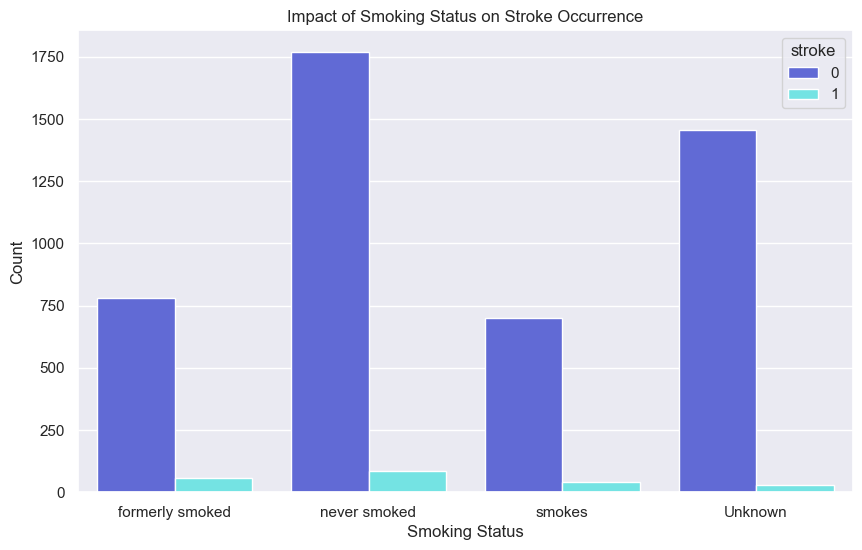

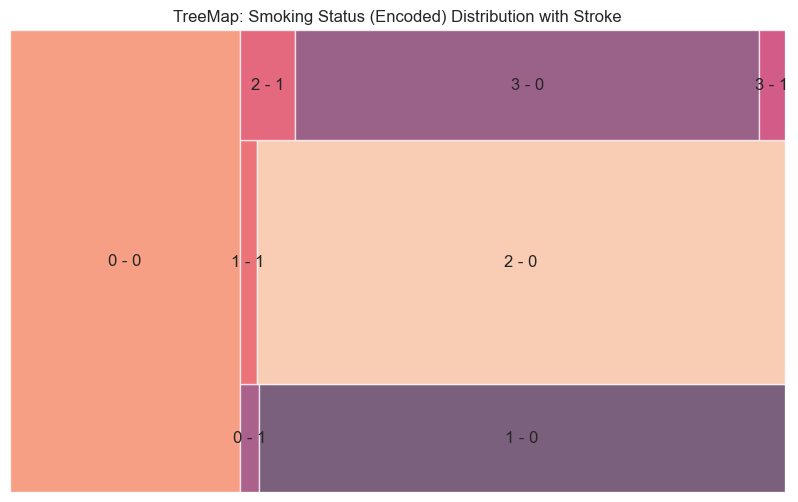

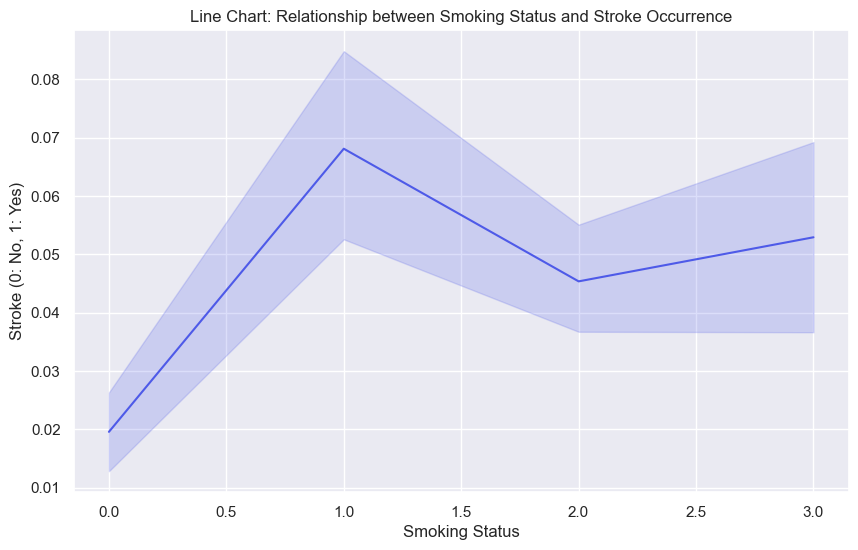

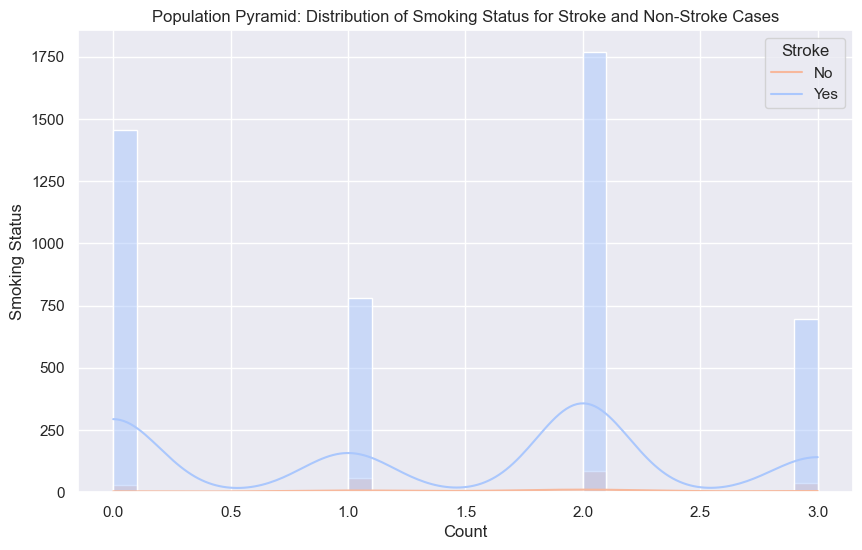

In [37]:
# Plotting the impact of smoking status on stroke occurrence
plt.figure(figsize=(10, 6))
sns.countplot(x='smoking_status', hue='stroke', data=df)
plt.title('Impact of Smoking Status on Stroke Occurrence')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.show()

# TreeMap for smoking status (encoded)
plt.figure(figsize=(10, 6))
df_smoking_encoded_count = df.groupby(['smoking_encoded', 'stroke']).size().reset_index(name='count')
squarify.plot(sizes=df_smoking_encoded_count['count'], label=df_smoking_encoded_count.apply(lambda x: f"{x['smoking_encoded']} - {x['stroke']}", axis=1), alpha=0.7)
plt.axis('off')
plt.title('TreeMap: Smoking Status (Encoded) Distribution with Stroke')
plt.show()

# Line chart for smoking status and stroke
plt.figure(figsize=(10, 6))
sns.lineplot(x='smoking_encoded', y='stroke', data=df)
plt.title('Line Chart: Relationship between Smoking Status and Stroke Occurrence')
plt.xlabel('Smoking Status')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='smoking_encoded', hue='stroke', bins=30, kde=True, multiple='layer', palette='coolwarm')
plt.title('Population Pyramid: Distribution of Smoking Status for Stroke and Non-Stroke Cases')
plt.xlabel('Count')
plt.ylabel('Smoking Status')
plt.legend(title='Stroke', labels=['No', 'Yes'])
plt.show()

<font color="bluegrey" size=+1.0><b>Research Question 11 → How do age and BMI collectively influence the likelihood of experiencing a stroke?</b></font>

In [48]:
# Encode age and BMI combinations
label_encoder = LabelEncoder()
df['age_bmi_encoded'] = label_encoder.fit_transform(df['age'].astype(str) + '_' + df['bmi'].astype(str))

# Splitting the dataset
X_train_age_bmi, X_test_age_bmi, y_train_age_bmi, y_test_age_bmi = train_test_split(df[['age_bmi_encoded']], y_binary, test_size=0.2, random_state=42)

# Training XGBoost classifier
xgb_age_bmi = XGBClassifier()
xgb_age_bmi.fit(X_train_age_bmi, y_train_age_bmi)

# Predictions on test set
y_pred_age_bmi = xgb_age_bmi.predict(X_test_age_bmi)

accuracy_age_bmi = accuracy_score(y_test_age_bmi, y_pred_age_bmi)
print("Accuracy:", accuracy_age_bmi)

print("Classification Report:")
print(classification_report(y_test_age_bmi, y_pred_age_bmi))


Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

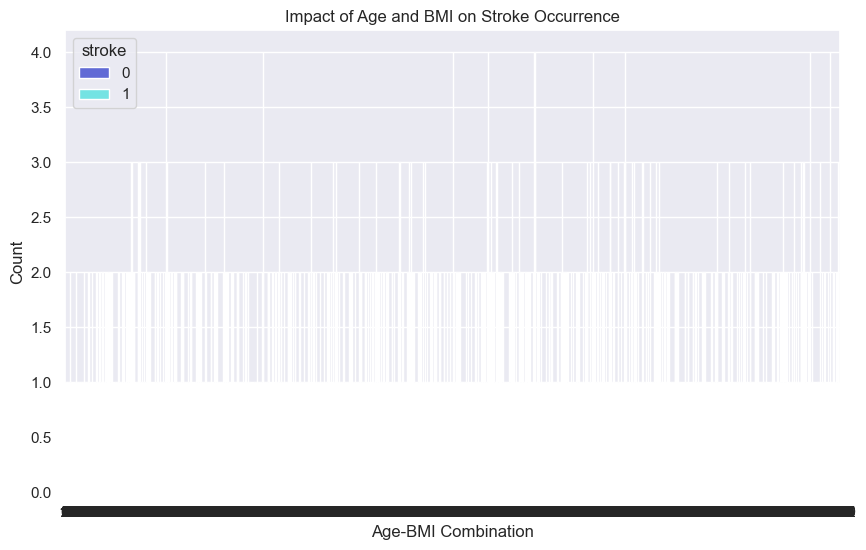

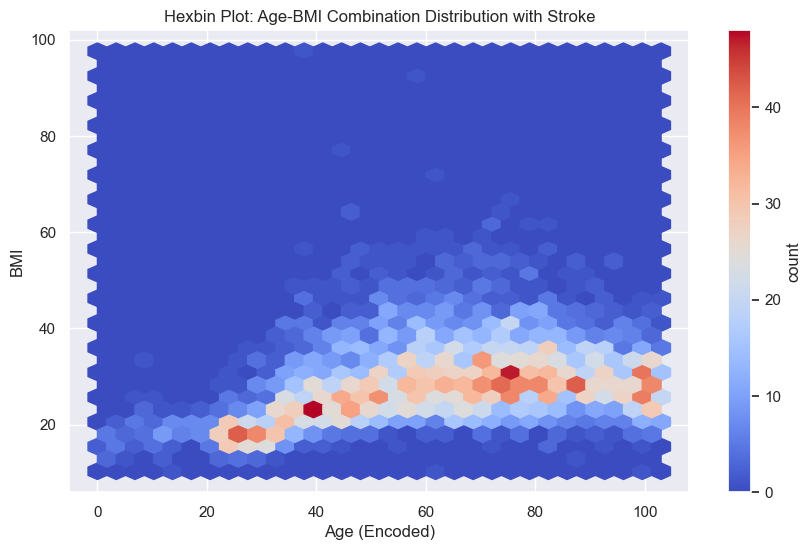

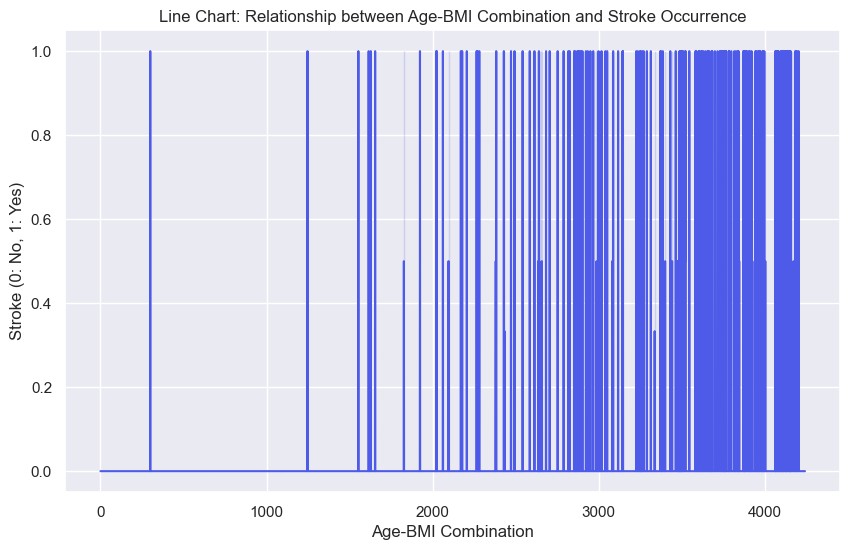

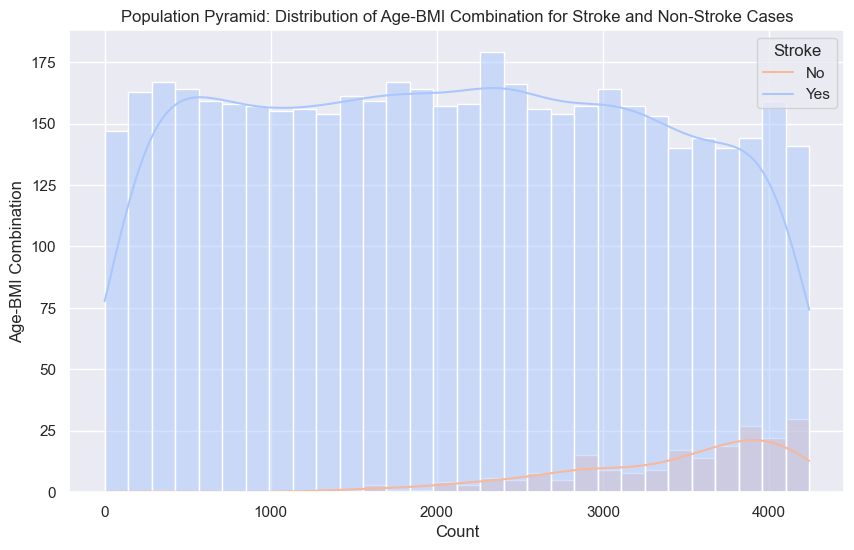

In [64]:
# Plotting the impact of age and BMI on stroke occurrence
plt.figure(figsize=(10, 6))
sns.countplot(x='age_bmi_encoded', hue='stroke', data=df)
plt.title('Impact of Age and BMI on Stroke Occurrence')
plt.xlabel('Age-BMI Combination')
plt.ylabel('Count')
plt.show()

# Scatter plot with hexagonal bins for age and BMI (encoded)
plt.figure(figsize=(10, 6))

# Drop duplicates to get unique combinations of age and BMI
unique_combinations_age_bmi = df[['age_encoded', 'bmi']].drop_duplicates()

# Create scatter plot with hexagonal bins
plt.hexbin(x=unique_combinations_age_bmi['age_encoded'], y=unique_combinations_age_bmi['bmi'], gridsize=30, cmap='coolwarm')

plt.colorbar(label='count')
plt.title('Hexbin Plot: Age-BMI Combination Distribution with Stroke')
plt.xlabel('Age (Encoded)')
plt.ylabel('BMI')
plt.show()

# Line chart for age, BMI, and stroke
plt.figure(figsize=(10, 6))
sns.lineplot(x='age_bmi_encoded', y='stroke', data=df)
plt.title('Line Chart: Relationship between Age-BMI Combination and Stroke Occurrence')
plt.xlabel('Age-BMI Combination')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age_bmi_encoded', hue='stroke', bins=30, kde=True, multiple='layer', palette='coolwarm')
plt.title('Population Pyramid: Distribution of Age-BMI Combination for Stroke and Non-Stroke Cases')
plt.xlabel('Count')
plt.ylabel('Age-BMI Combination')
plt.legend(title='Stroke', labels=['No', 'Yes'])
plt.show()

<font color="bluegrey" size=+1.0><b>Research Question 12 → How do age, hypertension, and smoking status collectively affect the probability of experiencing a stroke?</b></font>

In [53]:
label_encoder = LabelEncoder()
df['age_encoded'] = label_encoder.fit_transform(df['age'])
df['hypertension_encoded'] = label_encoder.fit_transform(df['hypertension'])
df['smoking_encoded'] = label_encoder.fit_transform(df['smoking_status'])

# Create the combined column
df['age_hyp_smoke_encoded'] = df['age_encoded'] * 100 + df['hypertension_encoded'] * 10 + df['smoking_encoded']

# Splitting the dataset
X_train_age_hyp_smoke, X_test_age_hyp_smoke, y_train_age_hyp_smoke, y_test_age_hyp_smoke = train_test_split(df[['age', 'hypertension', 'smoking_status']], y_binary, test_size=0.2, random_state=42)

# One-hot encode 'smoking_status' feature
encoder_smoking_status = OneHotEncoder(sparse=False)
X_train_age_hyp_smoke_encoded = encoder_smoking_status.fit_transform(X_train_age_hyp_smoke)
X_test_age_hyp_smoke_encoded = encoder_smoking_status.transform(X_test_age_hyp_smoke)

# Training XGBoost classifier
xgb_age_hyp_smoke = XGBClassifier()
xgb_age_hyp_smoke.fit(X_train_age_hyp_smoke_encoded, y_train_age_hyp_smoke)

# Predictions on test set
y_pred_age_hyp_smoke = xgb_age_hyp_smoke.predict(X_test_age_hyp_smoke_encoded)

accuracy_age_hyp_smoke = accuracy_score(y_test_age_hyp_smoke, y_pred_age_hyp_smoke)
print("Accuracy:", accuracy_age_hyp_smoke)

print("Classification Report:")
print(classification_report(y_test_age_hyp_smoke, y_pred_age_hyp_smoke))

Accuracy: 0.9460285132382892
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zen\

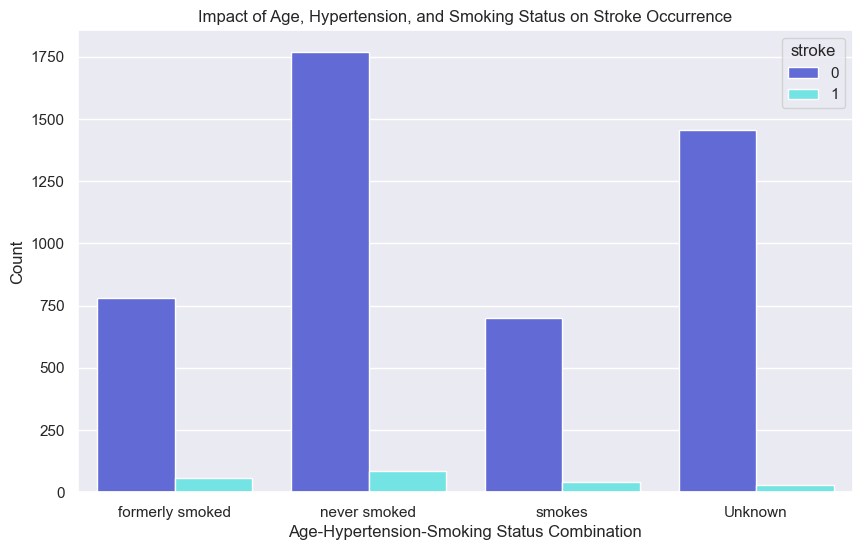

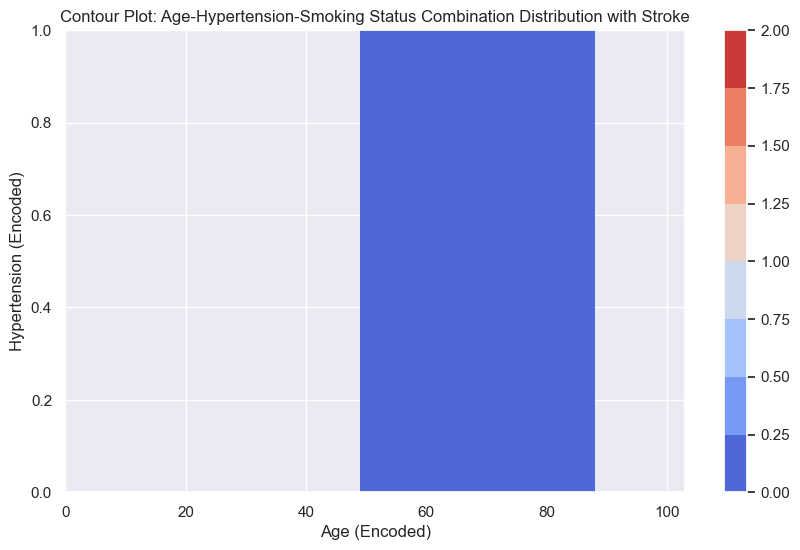

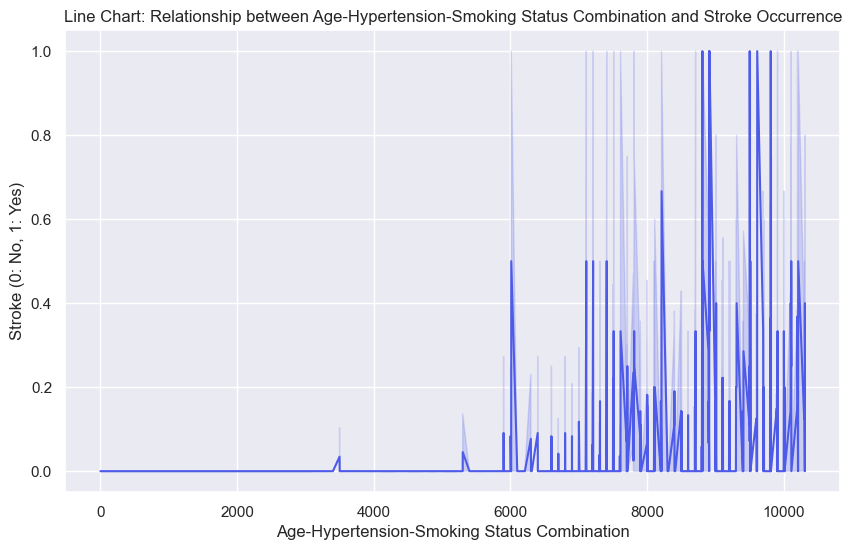

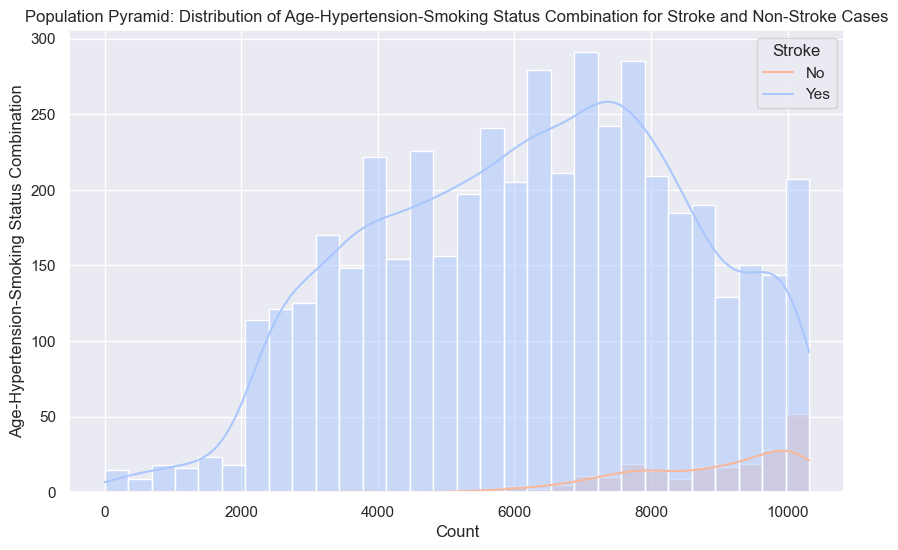

In [56]:
# Summary 
plt.figure(figsize=(10, 6))
sns.countplot(x='smoking_status', hue='stroke', data=df)
plt.title('Impact of Age, Hypertension, and Smoking Status on Stroke Occurrence')
plt.xlabel('Age-Hypertension-Smoking Status Combination')
plt.ylabel('Count')
plt.show()

# Contour plot for age, hypertension, and smoking status (encoded)
plt.figure(figsize=(10, 6))

unique_combinations = df[['age_encoded', 'hypertension_encoded', 'smoking_encoded']].drop_duplicates()

# Initialise z as a 2D array with zeros
Z = np.zeros_like(X)

# Iterate over unique combinations to populate Z
for index, row in unique_combinations.iterrows():
    age_enc = row['age_encoded']
    hyper_enc = row['hypertension_encoded']
    smoke_enc = row['smoking_encoded']
    stroke_count = df[(df['age_encoded'] == age_enc) & (df['hypertension_encoded'] == hyper_enc) & (df['smoking_encoded'] == smoke_enc)]['stroke'].sum()
    Z[row['hypertension_encoded'], row['age_encoded']] = stroke_count

# Plot the contour
contour = plt.contourf(X, Y, Z, cmap='coolwarm')
plt.colorbar(contour)

plt.title('Contour Plot: Age-Hypertension-Smoking Status Combination Distribution with Stroke')
plt.xlabel('Age (Encoded)')
plt.ylabel('Hypertension (Encoded)')
plt.show()

# Line chart for age, hypertension, smoking status, and stroke
plt.figure(figsize=(10, 6))
sns.lineplot(x='age_hyp_smoke_encoded', y='stroke', data=df)
plt.title('Line Chart: Relationship between Age-Hypertension-Smoking Status Combination and Stroke Occurrence')
plt.xlabel('Age-Hypertension-Smoking Status Combination')
plt.ylabel('Stroke (0: No, 1: Yes)')
plt.show()

# Pyramid
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age_hyp_smoke_encoded', hue='stroke', bins=30, kde=True, multiple='layer', palette='coolwarm')
plt.title('Population Pyramid: Distribution of Age-Hypertension-Smoking Status Combination for Stroke and Non-Stroke Cases')
plt.xlabel('Count')
plt.ylabel('Age-Hypertension-Smoking Status Combination')
plt.legend(title='Stroke', labels=['No', 'Yes'])
plt.show() 


<font color="greyblue" size=+2.0><b>XAI Implementation - Research Questions (combination variables)</b></font>

<font color="bluegrey" size=+1.0><b>Research Question 4 → What is the relationship between smoking status and the absence of stroke?</b></font>

<font color="bluegrey" size=+1.0><b>Research Question 5 → Does average glucose level correlate with the probability of stroke?</b></font>

<font color="bluegrey" size=+1.0><b>Research Question 11 → How do age and BMI collectively influence the likelihood of experiencing a stroke?</b></font>

<font color="bluegrey" size=+1.0><b>Research Question 12 → How do age, hypertension, and smoking status collectively affect the probability of experiencing a stroke?</b></font>